In [31]:
import os
import pickle
import warnings
from pathlib import Path
from typing import Tuple, Dict, Any, List
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    roc_curve, auc, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score
)
from sklearn.inspection import PartialDependenceDisplay

import xgboost as xgb
import optuna
from optuna.samplers import TPESampler

warnings.filterwarnings('ignore')
%matplotlib inline

# Set styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', 100)

print("All packages loaded successfully!")

All packages loaded successfully!


In [32]:
@dataclass
class Config:
    """Configuration class for model training"""
    # UPDATE THIS LINE - Change "." to your actual folder path
    DATA_DIR: Path = Path(".")  # <-- CHANGE THIS to where your CSV files are
    CLIENT_DATA: str = "client_data.csv"
    PRICE_DATA: str = "price_data.csv"
    
    # Model parameters
    TEST_SIZE: float = 0.25
    RANDOM_STATE: int = 42
    N_SPLITS: int = 5
    
    # Optimization
    N_TRIALS: int = 50
    TIMEOUT: int = 1800  # 30 minutes
    
    # Target column
    TARGET_COL: str = "churn"
    ID_COL: str = "id"

config = Config()

# Verify paths
print(f"Configuration loaded!")
print(f"\nLooking for data in: {config.DATA_DIR.absolute()}")
print(f"\nChecking files:")

client_path = config.DATA_DIR / config.CLIENT_DATA
price_path = config.DATA_DIR / config.PRICE_DATA

if client_path.exists():
    print(f"  ✓ {config.CLIENT_DATA} found!")
else:
    print(f"  ❌ {config.CLIENT_DATA} NOT found at {client_path}")
    
if price_path.exists():
    print(f"  ✓ {config.PRICE_DATA} found!")
else:
    print(f"  ❌ {config.PRICE_DATA} NOT found at {price_path}")

if client_path.exists() and price_path.exists():
    print("\n✓ All data files found! Ready to proceed.")
else:
    print("\n❌ Please update DATA_DIR in the Config class above")

Configuration loaded!

Looking for data in: c:\Users\Randall\Documents\Projects\python

Checking files:
  ✓ client_data.csv found!
  ✓ price_data.csv found!

✓ All data files found! Ready to proceed.


In [33]:
def load_and_merge_data(config: Config) -> pd.DataFrame:
    """Load and merge client and price data with preprocessing"""
    try:
        # Build file paths
        client_path = config.DATA_DIR / config.CLIENT_DATA
        price_path = config.DATA_DIR / config.PRICE_DATA
        
        # Check if files exist
        if not client_path.exists():
            raise FileNotFoundError(f"Client data not found: {client_path}")
        if not price_path.exists():
            raise FileNotFoundError(f"Price data not found: {price_path}")
        
        # Load data
        print("Loading client data...")
        client_data = pd.read_csv(client_path)
        print(f"✓ Client data loaded: {client_data.shape}")
        
        print("Loading price data...")
        price_data = pd.read_csv(price_path)
        print(f"✓ Price data loaded: {price_data.shape}")
        
        # Aggregate price data by id (create summary statistics from time series)
        print("\nAggregating price history data...")
        price_features = ['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var',
                         'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']
        
        agg_dict = {feat: ['mean', 'std', 'min', 'max'] for feat in price_features}
        price_agg = price_data.groupby('id').agg(agg_dict)
        
        # Flatten column names
        price_agg.columns = ['_'.join(col).strip() for col in price_agg.columns.values]
        price_agg = price_agg.reset_index()
        
        # Fill NaN values from std (when only one price point exists)
        price_agg = price_agg.fillna(0)
        
        print(f"✓ Aggregated price data: {price_agg.shape}")
        
        # Merge datasets
        print("\nMerging client and price data...")
        df = pd.merge(client_data, price_agg, on='id', how='inner')
        print(f"✓ Merged data: {df.shape}")
        print(f"  - Total customers: {len(df)}")
        print(f"  - Total features: {df.shape[1] - 2}")  # minus id and churn
        
        # Validate
        assert config.TARGET_COL in df.columns, f"{config.TARGET_COL} not found"
        assert config.ID_COL in df.columns, f"{config.ID_COL} not found"
        
        print(f"\n✓ Churn rate: {df[config.TARGET_COL].mean():.2%}")
        print(f"  - Churned: {df[config.TARGET_COL].sum()}")
        print(f"  - Retained: {(~df[config.TARGET_COL].astype(bool)).sum()}")
        
        return df
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        raise

# Load data
train = load_and_merge_data(config)
print(f"\n{'='*60}")
print("Data loading complete!")
print(f"{'='*60}")

Loading client data...
✓ Client data loaded: (14606, 26)
Loading price data...
✓ Price data loaded: (193002, 8)

Aggregating price history data...
✓ Aggregated price data: (16096, 25)

Merging client and price data...
✓ Merged data: (14606, 50)
  - Total customers: 14606
  - Total features: 48

✓ Churn rate: 9.72%
  - Churned: 1419
  - Retained: 13187

Data loading complete!


In [34]:
def preprocess_features(df: pd.DataFrame) -> pd.DataFrame:
    """Preprocess and engineer features from raw data"""
    df = df.copy()
    
    print(f"Starting feature engineering on {df.shape[0]} rows...")
    
    # 1. Convert date columns to datetime
    print("\n1. Processing date features...")
    date_cols = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # 2. Create date-based features
    if 'date_end' in df.columns and 'date_activ' in df.columns:
        df['tenure_days'] = (df['date_end'] - df['date_activ']).dt.days
        df['tenure_years'] = df['tenure_days'] / 365.25
        print("   ✓ Created tenure features")
    
    if 'date_end' in df.columns and 'date_modif_prod' in df.columns:
        df['days_since_modif'] = (df['date_end'] - df['date_modif_prod']).dt.days
        print("   ✓ Created modification recency feature")
    
    if 'date_end' in df.columns and 'date_renewal' in df.columns:
        df['days_to_renewal'] = (df['date_renewal'] - df['date_end']).dt.days
        print("   ✓ Created renewal timing feature")
    
    # Drop original date columns
    df = df.drop(columns=date_cols, errors='ignore')
    
    # 3. Encode categorical variables
    print("\n2. Encoding categorical features...")
    
    # Binary encoding for has_gas (t/f -> 1/0)
    if 'has_gas' in df.columns:
        df['has_gas'] = (df['has_gas'] == 't').astype(int)
        print("   ✓ Encoded has_gas")
    
    # One-hot encoding for channel_sales
    if 'channel_sales' in df.columns:
        df['channel_sales'] = df['channel_sales'].fillna('UNKNOWN')
        dummies = pd.get_dummies(df['channel_sales'], prefix='channel', drop_first=True)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(columns=['channel_sales'])
        print(f"   ✓ One-hot encoded channel_sales ({len(dummies.columns)} categories)")
    
    # One-hot encoding for origin_up
    if 'origin_up' in df.columns:
        df['origin_up'] = df['origin_up'].fillna('UNKNOWN')
        dummies = pd.get_dummies(df['origin_up'], prefix='origin', drop_first=True)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(columns=['origin_up'])
        print(f"   ✓ One-hot encoded origin_up ({len(dummies.columns)} categories)")
    
    # 4. Handle any remaining missing values
    print("\n3. Handling missing values...")
    missing_before = df.isnull().sum().sum()
    df = df.fillna(0)
    print(f"   ✓ Filled {missing_before} missing values with 0")
    
    print(f"\n{'='*60}")
    print(f"Feature engineering complete!")
    print(f"  - Final shape: {df.shape}")
    print(f"  - Total features: {df.shape[1] - 2}")  # minus id and churn
    print(f"{'='*60}\n")
    
    return df

# Apply preprocessing
train = preprocess_features(train)
print("Preview of processed data:")
print(train.head())

Starting feature engineering on 14606 rows...

1. Processing date features...
   ✓ Created tenure features
   ✓ Created modification recency feature
   ✓ Created renewal timing feature

2. Encoding categorical features...
   ✓ Encoded has_gas
   ✓ One-hot encoded channel_sales (7 categories)
   ✓ One-hot encoded origin_up (5 categories)

3. Handling missing values...
   ✓ Filled 0 missing values with 0

Feature engineering complete!
  - Final shape: (14606, 60)
  - Total features: 58

Preview of processed data:
                                 id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57         0         54946                0   
1  d29c2c54acc38ff3c0614d0a653813dd      4660             0                0   
2  764c75f661154dac3a6c254cd082ea7d       544             0                0   
3  bba03439a292a1e166f80264c16191cb      1584             0                0   
4  149d57cf92fc41cf94415803a877cb4b      4425             0              526   

  

In [35]:
def prepare_data(df: pd.DataFrame, config: Config) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, pd.Index]:
    """Prepare features and target, split into train/test"""
    # Separate features and target
    y = df[config.TARGET_COL].values
    X = df.drop(columns=[config.ID_COL, config.TARGET_COL])
    
    feature_names = X.columns
    X = X.values
    
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=config.TEST_SIZE, 
        random_state=config.RANDOM_STATE,
        stratify=y
    )
    
    print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")
    print(f"Train churn rate: {y_train.mean():.2%}")
    print(f"Test churn rate: {y_test.mean():.2%}")
    
    return X_train, X_test, y_train, y_test, feature_names

X_train, X_test, y_train, y_test, feature_names = prepare_data(train, config)

Train set: (10954, 58), Test set: (3652, 58)
Train churn rate: 9.71%
Test churn rate: 9.72%


In [48]:
def train_baseline_model(X_train: np.ndarray, y_train: np.ndarray) -> xgb.XGBClassifier:
    """Train a baseline XGBoost model with sensible defaults"""
    model = xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=6,
        n_estimators=500,
        n_jobs=-1,
        random_state=42,
        eval_metric='logloss',
        verbosity=0
    )
    
    # Train with early stopping (fixed for newer XGBoost versions)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train)],
        verbose=False
    )
    
    return model

baseline_model = train_baseline_model(X_train, y_train)
print(f"Baseline model trained")

Baseline model trained


In [37]:
def evaluate_model(model, X_test: np.ndarray, y_test: np.ndarray) -> pd.DataFrame:
    """Comprehensive model evaluation"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    results = pd.DataFrame({
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred)],
        'Recall': [recall_score(y_test, y_pred)],
        'ROC-AUC': [roc_auc_score(y_test, y_pred_proba)]
    })
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return results

def plot_roc_curve(model, X_test: np.ndarray, y_test: np.ndarray, title: str = "ROC Curve"):
    """Plot ROC curve with AUC score"""
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3297
           1       0.46      0.09      0.15       355

    accuracy                           0.90      3652
   macro avg       0.69      0.54      0.55      3652
weighted avg       0.87      0.90      0.87      3652


Baseline Results:
   Accuracy  Precision    Recall  ROC-AUC
0  0.901424   0.462687  0.087324  0.67851


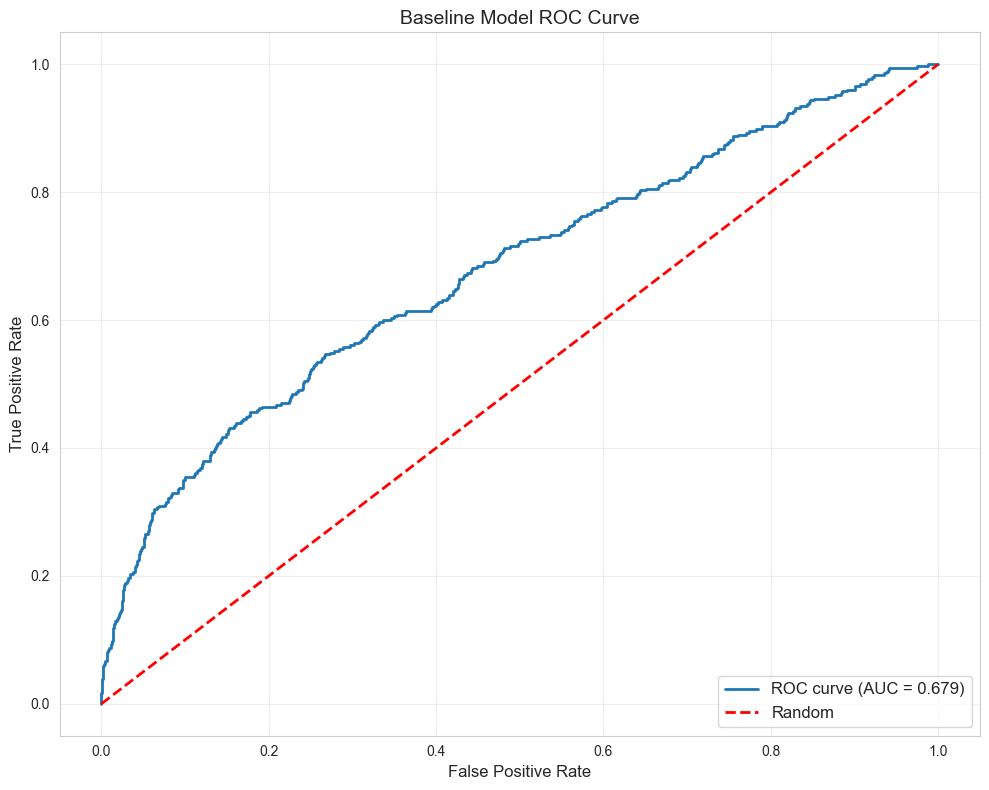

In [38]:
# Evaluate baseline
baseline_results = evaluate_model(baseline_model, X_test, y_test)
print("\nBaseline Results:")
print(baseline_results)
plot_roc_curve(baseline_model, X_test, y_test, "Baseline Model ROC Curve")


BASELINE MODEL - ROC CURVE VISUALIZATION


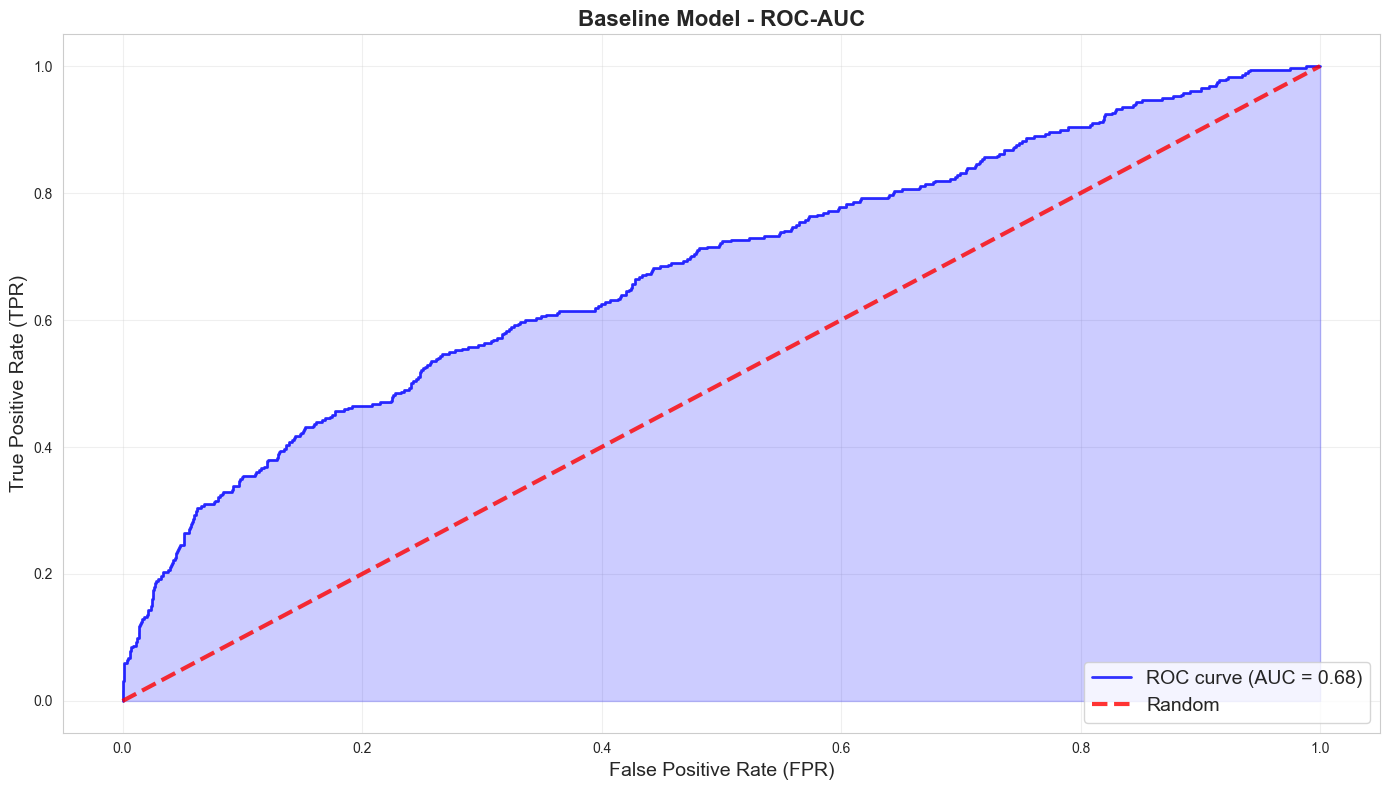

In [39]:
# Enhanced ROC curve visualization with more details
def plot_enhanced_roc_curve(model, X_test, y_test, title="ROC-AUC Curve"):
    """Plot enhanced ROC curve with confidence metrics"""
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot ROC curve
    ax.plot(fpr, tpr, lw=2, alpha=0.8, color='blue',
            label=f'ROC curve (AUC = {roc_auc:.2f})')
    
    # Plot random classifier line
    ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='red',
            label='Random', alpha=0.8)
    
    # Styling
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=14)
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=14)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.legend(loc="lower right", fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Add diagonal fill
    ax.fill_between(fpr, tpr, alpha=0.2, color='blue')
    
    plt.tight_layout()
    plt.show()
    
    return fpr, tpr, roc_auc

# Plot enhanced ROC for baseline
print("\n" + "="*60)
print("BASELINE MODEL - ROC CURVE VISUALIZATION")
print("="*60)
fpr_base, tpr_base, auc_base = plot_enhanced_roc_curve(
    baseline_model, X_test, y_test, 
    "Baseline Model - ROC-AUC"
)

In [49]:
def cross_validate_model(model, X: np.ndarray, y: np.ndarray, n_splits: int = 5) -> Tuple[List, List, List]:
    """Perform stratified k-fold cross-validation"""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fprs, tprs, aucs = [], [], []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Train model
        fold_model = model.__class__(**model.get_params())
        fold_model.fit(X_train_fold, y_train_fold, verbose=False)
        
        # Predict
        y_pred_proba = fold_model.predict_proba(X_val_fold)[:, 1]
        fpr, tpr, _ = roc_curve(y_val_fold, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(roc_auc)
        
        print(f"Fold {fold}: AUC = {roc_auc:.4f}")
    
    print(f"\nMean AUC: {np.mean(aucs):.4f} (+/- {np.std(aucs):.4f})")
    
    return fprs, tprs, aucs

In [41]:
def plot_cv_roc_curves(fprs: List, tprs: List, aucs: List):
    """Plot ROC curves from cross-validation"""
    mean_fpr = np.linspace(0, 1, 100)
    tprs_interp = []
    
    plt.figure(figsize=(12, 8))
    
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {aucs[i]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random')
    
    # Plot mean ROC
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, 'b-', lw=3, 
             label=f'Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
    
    # Plot confidence interval
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', 
                     alpha=0.2, label='± 1 std. dev.')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Cross-Validation ROC Curves', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Fold 1: AUC = 0.6916
Fold 2: AUC = 0.6828
Fold 3: AUC = 0.6814
Fold 4: AUC = 0.6887
Fold 5: AUC = 0.7019

Mean AUC: 0.6893 (+/- 0.0073)


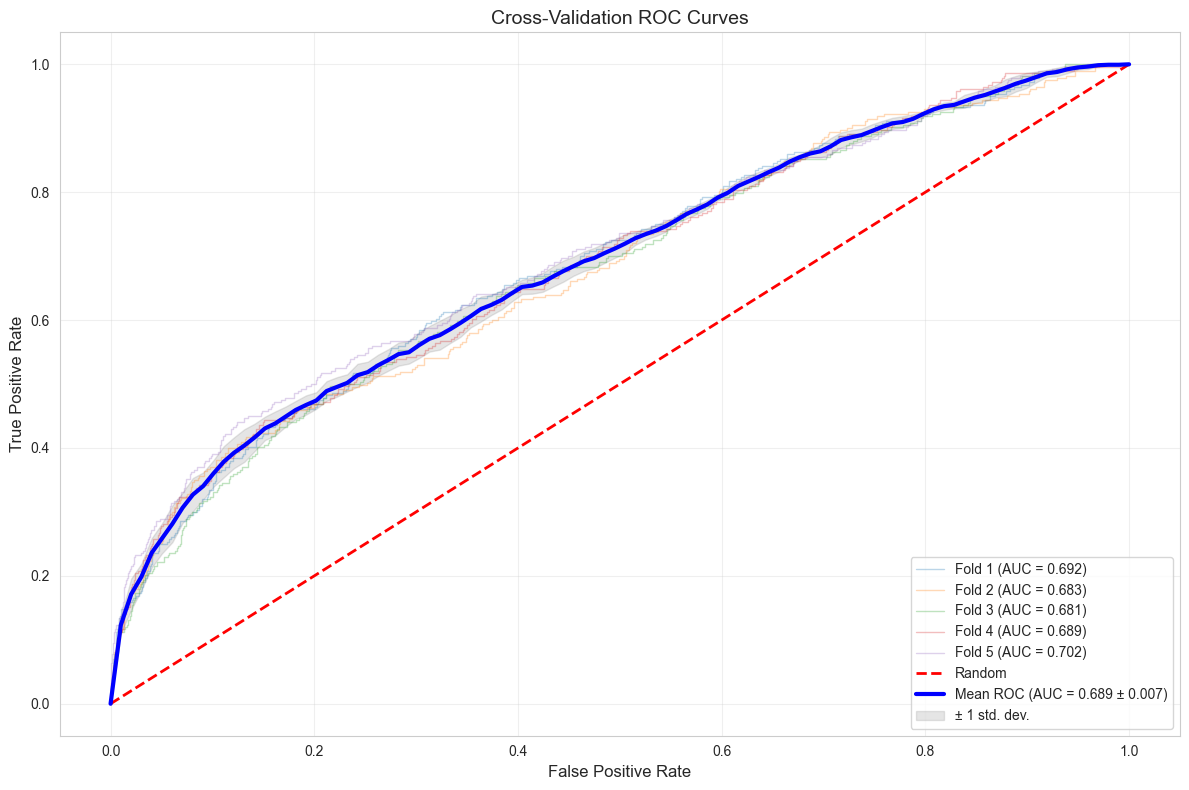

In [42]:
# Perform CV on baseline
X_full = np.vstack([X_train, X_test])
y_full = np.concatenate([y_train, y_test])

fprs, tprs, aucs = cross_validate_model(baseline_model, X_full, y_full, config.N_SPLITS)
plot_cv_roc_curves(fprs, tprs, aucs)


BASELINE MODEL - STRATIFIED K-FOLD CROSS-VALIDATION


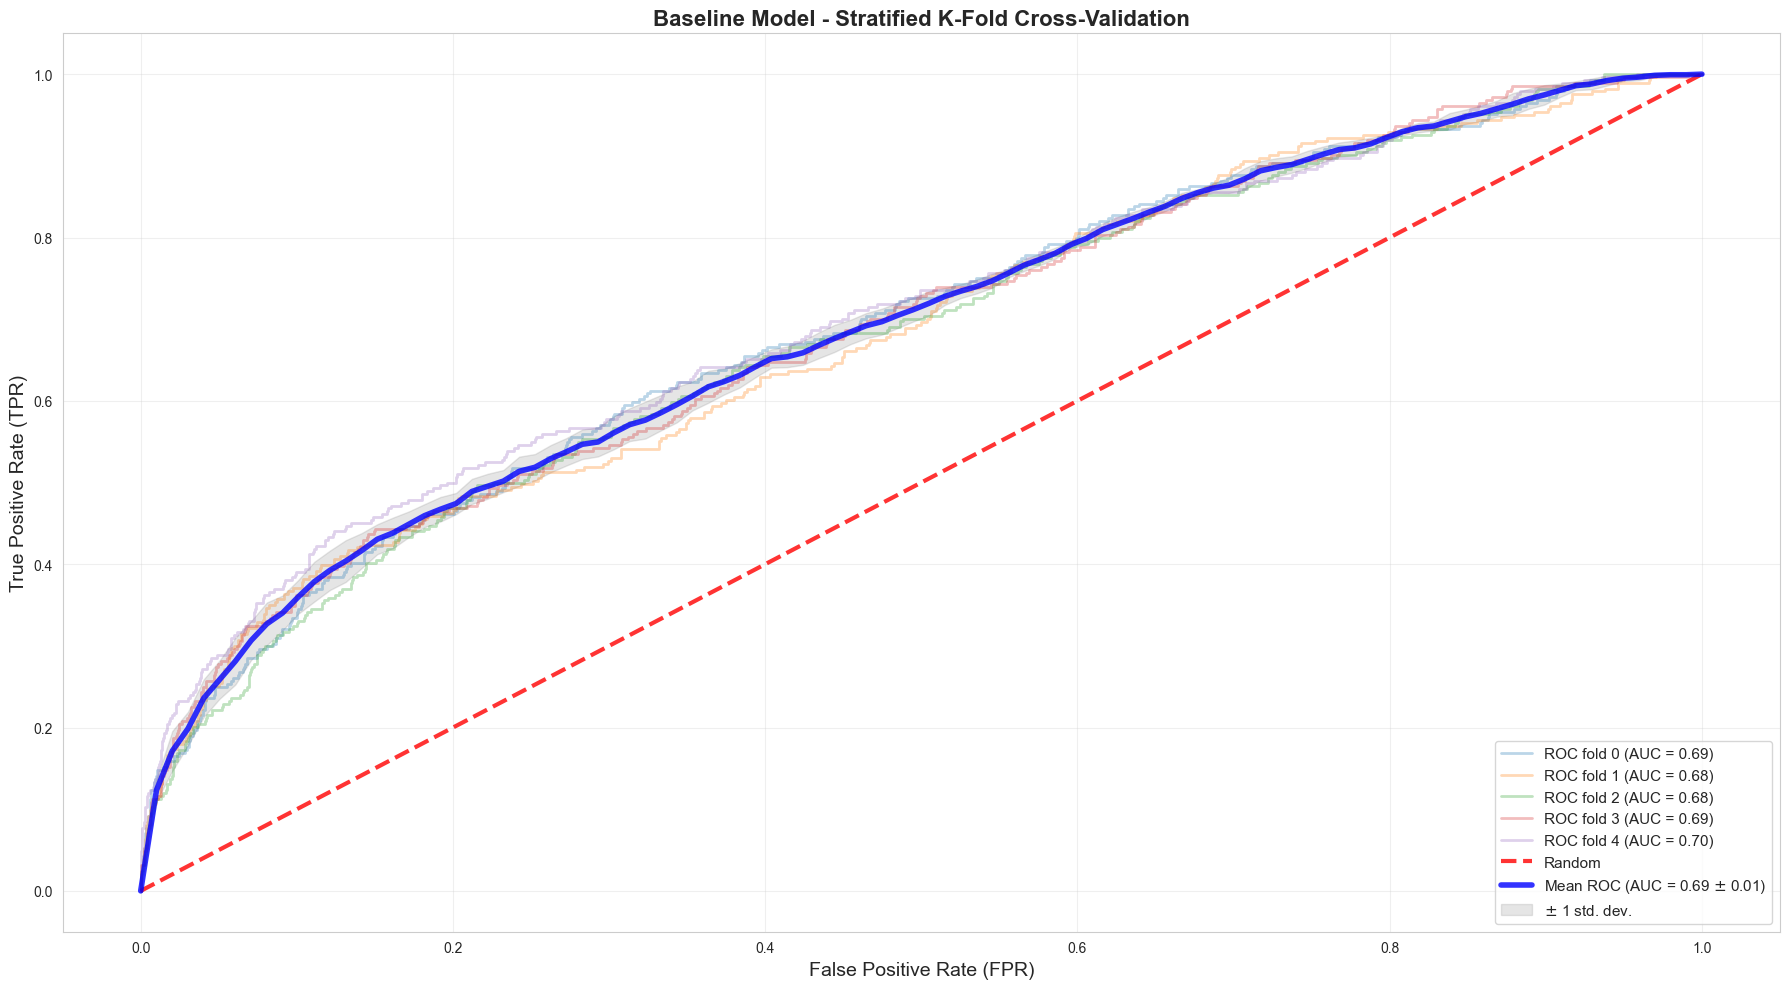


Mean AUC: 0.6893 ± 0.0073


In [43]:
def plot_stratified_kfold_roc(fprs, tprs, aucs, title="Stratified K-Fold Cross-Validation"):
    """
    Enhanced visualization of ROC curves from stratified k-fold CV
    Matches the style from the original PDF
    """
    mean_fpr = np.linspace(0, 1, 100)
    tprs_interp = []
    
    fig, ax = plt.subplots(figsize=(18, 10))
    
    # Plot individual fold ROC curves
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        ax.plot(fpr, tpr, lw=2, alpha=0.3,
                label=f'ROC fold {i} (AUC = {aucs[i]:.2f})')
    
    # Plot random classifier
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
             label='Random', alpha=0.8)
    
    # Calculate and plot mean ROC
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=4, alpha=0.8)
    
    # Plot confidence interval
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                    label=r'$\pm$ 1 std. dev.')
    
    # Styling
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=14)
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=14)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.legend(loc='lower right', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return mean_auc, std_auc

# Enhanced visualization for baseline CV
print("\n" + "="*60)
print("BASELINE MODEL - STRATIFIED K-FOLD CROSS-VALIDATION")
print("="*60)
mean_auc, std_auc = plot_stratified_kfold_roc(
    fprs, tprs, aucs,
    "Baseline Model - Stratified K-Fold Cross-Validation"
)
print(f"\nMean AUC: {mean_auc:.4f} ± {std_auc:.4f}")

In [50]:
def objective(trial: optuna.Trial) -> float:
    """Optuna objective function for hyperparameter optimization"""
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'random_state': 42,
        'n_jobs': -1,
        'eval_metric': 'logloss',
        'verbosity': 0
    }
    
    # Cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_tr, y_tr, verbose=False)
        
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred_proba)
        scores.append(score)
    
    return np.mean(scores)

In [52]:
def optimize_hyperparameters(n_trials: int = 100, timeout: int = 3600) -> Dict[str, Any]:
    """Run Optuna optimization"""
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42)
    )
    
    study.optimize(
        objective, 
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True
    )
    
    print(f"\nBest trial: {study.best_trial.number}")
    print(f"Best ROC-AUC: {study.best_value:.4f}")
    print("\nBest hyperparameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    return study.best_params

# Run optimization (reduce n_trials for faster execution)
best_params = optimize_hyperparameters(n_trials=50, timeout=1800)

[I 2026-01-01 15:25:16,301] A new study created in memory with name: no-name-ee3c448c-58d8-47ca-8c95-73fbc1a83bb1
Best trial: 0. Best value: 0.663986:   2%|▏         | 1/50 [00:08<07:15,  8.89s/it, 8.89/1800 seconds]

[I 2026-01-01 15:25:25,193] Trial 0 finished with value: 0.6639860809203135 and parameters: {'max_depth': 7, 'learning_rate': 0.07969454818643935, 'n_estimators': 1500, 'min_child_weight': 6, 'gamma': 0.7800932022121826, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088, 'scale_pos_weight': 7.372653200164409}. Best is trial 0 with value: 0.6639860809203135.


Best trial: 1. Best value: 0.666634:   4%|▍         | 2/50 [00:15<06:07,  7.65s/it, 15.68/1800 seconds]

[I 2026-01-01 15:25:31,980] Trial 1 finished with value: 0.6666335066890717 and parameters: {'max_depth': 3, 'learning_rate': 0.08706020878304858, 'n_estimators': 1700, 'min_child_weight': 3, 'gamma': 0.9091248360355031, 'subsample': 0.5917022549267169, 'colsample_bytree': 0.6521211214797689, 'reg_alpha': 0.5247564316322378, 'reg_lambda': 0.43194501864211576, 'scale_pos_weight': 3.6210622617823773}. Best is trial 1 with value: 0.6666335066890717.


Best trial: 2. Best value: 0.677618:   6%|▌         | 3/50 [00:25<06:42,  8.56s/it, 25.33/1800 seconds]

[I 2026-01-01 15:25:41,627] Trial 2 finished with value: 0.6776183140448094 and parameters: {'max_depth': 10, 'learning_rate': 0.0019010245319870357, 'n_estimators': 600, 'min_child_weight': 4, 'gamma': 2.28034992108518, 'subsample': 0.8925879806965068, 'colsample_bytree': 0.5998368910791798, 'reg_alpha': 0.5142344384136116, 'reg_lambda': 0.5924145688620425, 'scale_pos_weight': 1.4180537144799796}. Best is trial 2 with value: 0.6776183140448094.


Best trial: 2. Best value: 0.677618:   8%|▊         | 4/50 [00:29<05:12,  6.80s/it, 29.43/1800 seconds]

[I 2026-01-01 15:25:45,732] Trial 3 finished with value: 0.6750326271064925 and parameters: {'max_depth': 10, 'learning_rate': 0.002193048555664369, 'n_estimators': 200, 'min_child_weight': 10, 'gamma': 4.828160165372797, 'subsample': 0.9041986740582306, 'colsample_bytree': 0.6523068845866853, 'reg_alpha': 0.09767211400638387, 'reg_lambda': 0.6842330265121569, 'scale_pos_weight': 4.961372443656412}. Best is trial 2 with value: 0.6776183140448094.


Best trial: 2. Best value: 0.677618:  10%|█         | 5/50 [00:30<03:29,  4.66s/it, 30.30/1800 seconds]

[I 2026-01-01 15:25:46,598] Trial 4 finished with value: 0.6625771516917175 and parameters: {'max_depth': 4, 'learning_rate': 0.009780337016659405, 'n_estimators': 100, 'min_child_weight': 10, 'gamma': 1.2938999080000846, 'subsample': 0.831261142176991, 'colsample_bytree': 0.6558555380447055, 'reg_alpha': 0.5200680211778108, 'reg_lambda': 0.5467102793432796, 'scale_pos_weight': 2.6636900997297435}. Best is trial 2 with value: 0.6776183140448094.


Best trial: 5. Best value: 0.683666:  12%|█▏        | 6/50 [00:36<03:49,  5.22s/it, 36.59/1800 seconds]

[I 2026-01-01 15:25:52,895] Trial 5 finished with value: 0.6836664566908808 and parameters: {'max_depth': 15, 'learning_rate': 0.035503048581283086, 'n_estimators': 1900, 'min_child_weight': 9, 'gamma': 2.9894998940554256, 'subsample': 0.9609371175115584, 'colsample_bytree': 0.5442462510259598, 'reg_alpha': 0.1959828624191452, 'reg_lambda': 0.045227288910538066, 'scale_pos_weight': 3.927972976869379}. Best is trial 5 with value: 0.6836664566908808.


Best trial: 5. Best value: 0.683666:  14%|█▍        | 7/50 [00:58<07:43, 10.78s/it, 58.83/1800 seconds]

[I 2026-01-01 15:26:15,131] Trial 6 finished with value: 0.6794152463551412 and parameters: {'max_depth': 8, 'learning_rate': 0.003488976654890368, 'n_estimators': 1700, 'min_child_weight': 4, 'gamma': 1.4046725484369038, 'subsample': 0.7713480415791243, 'colsample_bytree': 0.5704621124873813, 'reg_alpha': 0.8021969807540397, 'reg_lambda': 0.07455064367977082, 'scale_pos_weight': 9.881982429404655}. Best is trial 5 with value: 0.6836664566908808.


Best trial: 5. Best value: 0.683666:  16%|█▌        | 8/50 [01:01<05:41,  8.14s/it, 61.32/1800 seconds]

[I 2026-01-01 15:26:17,621] Trial 7 finished with value: 0.6637839017726139 and parameters: {'max_depth': 13, 'learning_rate': 0.002497073714505273, 'n_estimators': 100, 'min_child_weight': 9, 'gamma': 3.534286719238086, 'subsample': 0.8645035840204937, 'colsample_bytree': 0.8856351733429728, 'reg_alpha': 0.07404465173409036, 'reg_lambda': 0.3584657285442726, 'scale_pos_weight': 2.0428215357261674}. Best is trial 5 with value: 0.6836664566908808.


Best trial: 5. Best value: 0.683666:  18%|█▊        | 9/50 [01:16<07:08, 10.45s/it, 76.84/1800 seconds]

[I 2026-01-01 15:26:33,135] Trial 8 finished with value: 0.6836027195102062 and parameters: {'max_depth': 14, 'learning_rate': 0.01764396768338155, 'n_estimators': 700, 'min_child_weight': 1, 'gamma': 1.554911608578311, 'subsample': 0.6625916610133735, 'colsample_bytree': 0.864803089169032, 'reg_alpha': 0.6375574713552131, 'reg_lambda': 0.8872127425763265, 'scale_pos_weight': 5.249934326457543}. Best is trial 5 with value: 0.6836664566908808.


Best trial: 5. Best value: 0.683666:  20%|██        | 10/50 [01:22<06:00,  9.02s/it, 82.65/1800 seconds]

[I 2026-01-01 15:26:38,945] Trial 9 finished with value: 0.6817425689940585 and parameters: {'max_depth': 4, 'learning_rate': 0.026698666742744605, 'n_estimators': 1600, 'min_child_weight': 6, 'gamma': 3.854835899772805, 'subsample': 0.7468977981821954, 'colsample_bytree': 0.7613664146909971, 'reg_alpha': 0.42754101835854963, 'reg_lambda': 0.02541912674409519, 'scale_pos_weight': 1.97102284293974}. Best is trial 5 with value: 0.6836664566908808.


Best trial: 5. Best value: 0.683666:  22%|██▏       | 11/50 [01:30<05:39,  8.71s/it, 90.65/1800 seconds]

[I 2026-01-01 15:26:46,953] Trial 10 finished with value: 0.6791234761205894 and parameters: {'max_depth': 15, 'learning_rate': 0.03363458701677612, 'n_estimators': 2000, 'min_child_weight': 8, 'gamma': 3.1008622647777737, 'subsample': 0.9538323976412588, 'colsample_bytree': 0.97988537297271, 'reg_alpha': 0.28507989151201407, 'reg_lambda': 0.21246987241999943, 'scale_pos_weight': 7.3293273591518995}. Best is trial 5 with value: 0.6836664566908808.


Best trial: 11. Best value: 0.684257:  24%|██▍       | 12/50 [01:47<07:04, 11.18s/it, 107.50/1800 seconds]

[I 2026-01-01 15:27:03,798] Trial 11 finished with value: 0.6842572539899502 and parameters: {'max_depth': 15, 'learning_rate': 0.013093310334961418, 'n_estimators': 1000, 'min_child_weight': 1, 'gamma': 2.2574084326541852, 'subsample': 0.6810736541687963, 'colsample_bytree': 0.8035921370166128, 'reg_alpha': 0.7116574996731307, 'reg_lambda': 0.9378362838951788, 'scale_pos_weight': 4.7165267822660395}. Best is trial 11 with value: 0.6842572539899502.


Best trial: 12. Best value: 0.686539:  26%|██▌       | 13/50 [02:07<08:31, 13.83s/it, 127.41/1800 seconds]

[I 2026-01-01 15:27:23,707] Trial 12 finished with value: 0.6865387883548997 and parameters: {'max_depth': 12, 'learning_rate': 0.008282765415726022, 'n_estimators': 1100, 'min_child_weight': 1, 'gamma': 2.449034676984989, 'subsample': 0.7064320329894239, 'colsample_bytree': 0.7648966663672004, 'reg_alpha': 0.9960165317474352, 'reg_lambda': 0.9829075464717237, 'scale_pos_weight': 3.8305717199861506}. Best is trial 12 with value: 0.6865387883548997.


Best trial: 12. Best value: 0.686539:  28%|██▊       | 14/50 [02:34<10:45, 17.93s/it, 154.83/1800 seconds]

[I 2026-01-01 15:27:51,134] Trial 13 finished with value: 0.6860033198860521 and parameters: {'max_depth': 12, 'learning_rate': 0.0067609587675070346, 'n_estimators': 1200, 'min_child_weight': 1, 'gamma': 2.1633659672627528, 'subsample': 0.6945281648508165, 'colsample_bytree': 0.7730251035808603, 'reg_alpha': 0.965337946065455, 'reg_lambda': 0.9949264907950778, 'scale_pos_weight': 6.346453944998581}. Best is trial 12 with value: 0.6865387883548997.


Best trial: 12. Best value: 0.686539:  30%|███       | 15/50 [03:02<12:14, 20.98s/it, 182.88/1800 seconds]

[I 2026-01-01 15:28:19,179] Trial 14 finished with value: 0.6860408920860125 and parameters: {'max_depth': 12, 'learning_rate': 0.006236919759778202, 'n_estimators': 1200, 'min_child_weight': 2, 'gamma': 2.261631564388042, 'subsample': 0.6924745509172271, 'colsample_bytree': 0.776245753066737, 'reg_alpha': 0.969269852048718, 'reg_lambda': 0.8117185474709656, 'scale_pos_weight': 6.763850726289618}. Best is trial 12 with value: 0.6865387883548997.


Best trial: 12. Best value: 0.686539:  32%|███▏      | 16/50 [03:34<13:40, 24.13s/it, 214.31/1800 seconds]

[I 2026-01-01 15:28:50,615] Trial 15 finished with value: 0.6824710746704398 and parameters: {'max_depth': 12, 'learning_rate': 0.0049109214174368684, 'n_estimators': 1300, 'min_child_weight': 3, 'gamma': 0.023700598265448125, 'subsample': 0.510456783241702, 'colsample_bytree': 0.7100768527915096, 'reg_alpha': 0.9866505326900652, 'reg_lambda': 0.7637473949148526, 'scale_pos_weight': 8.989970237525279}. Best is trial 12 with value: 0.6865387883548997.


Best trial: 12. Best value: 0.686539:  34%|███▍      | 17/50 [04:05<14:30, 26.39s/it, 245.97/1800 seconds]

[I 2026-01-01 15:29:22,274] Trial 16 finished with value: 0.6764513712379306 and parameters: {'max_depth': 11, 'learning_rate': 0.0011335431394085076, 'n_estimators': 900, 'min_child_weight': 2, 'gamma': 4.353140005759698, 'subsample': 0.7517946962798956, 'colsample_bytree': 0.843625566043863, 'reg_alpha': 0.842550600752501, 'reg_lambda': 0.810166792842588, 'scale_pos_weight': 6.430064107276092}. Best is trial 12 with value: 0.6865387883548997.


Best trial: 12. Best value: 0.686539:  36%|███▌      | 18/50 [04:21<12:22, 23.20s/it, 261.75/1800 seconds]

[I 2026-01-01 15:29:38,048] Trial 17 finished with value: 0.681475587537109 and parameters: {'max_depth': 7, 'learning_rate': 0.007205326249728212, 'n_estimators': 1300, 'min_child_weight': 5, 'gamma': 2.825269757813548, 'subsample': 0.6200127279751557, 'colsample_bytree': 0.9268730380586729, 'reg_alpha': 0.7083352807284711, 'reg_lambda': 0.8187568380821288, 'scale_pos_weight': 8.27177181073599}. Best is trial 12 with value: 0.6865387883548997.


Best trial: 18. Best value: 0.689022:  38%|███▊      | 19/50 [04:44<11:52, 22.98s/it, 284.21/1800 seconds]

[I 2026-01-01 15:30:00,515] Trial 18 finished with value: 0.6890219890536379 and parameters: {'max_depth': 13, 'learning_rate': 0.004382767753262865, 'n_estimators': 700, 'min_child_weight': 2, 'gamma': 1.9148297678383006, 'subsample': 0.7985061943499071, 'colsample_bytree': 0.7190390406576248, 'reg_alpha': 0.9104019625812277, 'reg_lambda': 0.9984774961213039, 'scale_pos_weight': 3.5592416816700116}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  40%|████      | 20/50 [04:59<10:19, 20.66s/it, 299.46/1800 seconds]

[I 2026-01-01 15:30:15,764] Trial 19 finished with value: 0.6829730408354965 and parameters: {'max_depth': 13, 'learning_rate': 0.0040492462134747624, 'n_estimators': 400, 'min_child_weight': 2, 'gamma': 1.7768915778117162, 'subsample': 0.8058051674243758, 'colsample_bytree': 0.7160733764154752, 'reg_alpha': 0.8731424285218723, 'reg_lambda': 0.9938427850497087, 'scale_pos_weight': 3.240503053977148}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  42%|████▏     | 21/50 [05:15<09:20, 19.33s/it, 315.70/1800 seconds]

[I 2026-01-01 15:30:32,001] Trial 20 finished with value: 0.6809590713449284 and parameters: {'max_depth': 9, 'learning_rate': 0.001346294122325654, 'n_estimators': 700, 'min_child_weight': 3, 'gamma': 0.3227297584749178, 'subsample': 0.8069832246374763, 'colsample_bytree': 0.7147571152200868, 'reg_alpha': 0.6427453686954361, 'reg_lambda': 0.6917693465405778, 'scale_pos_weight': 4.164595850744106}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  44%|████▍     | 22/50 [05:38<09:33, 20.46s/it, 338.81/1800 seconds]

[I 2026-01-01 15:30:55,108] Trial 21 finished with value: 0.6877197183170763 and parameters: {'max_depth': 12, 'learning_rate': 0.006402123356520579, 'n_estimators': 900, 'min_child_weight': 2, 'gamma': 2.6365604974902332, 'subsample': 0.7231027201062123, 'colsample_bytree': 0.8142982175167216, 'reg_alpha': 0.9905090469389144, 'reg_lambda': 0.8842845652144962, 'scale_pos_weight': 6.107091063216304}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  46%|████▌     | 23/50 [05:55<08:39, 19.24s/it, 355.19/1800 seconds]

[I 2026-01-01 15:31:11,493] Trial 22 finished with value: 0.6875929935532629 and parameters: {'max_depth': 13, 'learning_rate': 0.010624114384676767, 'n_estimators': 900, 'min_child_weight': 2, 'gamma': 2.8189364840949667, 'subsample': 0.7318988257590423, 'colsample_bytree': 0.8184415340894485, 'reg_alpha': 0.9994134940876853, 'reg_lambda': 0.9020315293296745, 'scale_pos_weight': 5.711442496156378}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  48%|████▊     | 24/50 [06:04<07:02, 16.25s/it, 364.46/1800 seconds]

[I 2026-01-01 15:31:20,765] Trial 23 finished with value: 0.6855888209950273 and parameters: {'max_depth': 14, 'learning_rate': 0.019242339996913084, 'n_estimators': 900, 'min_child_weight': 4, 'gamma': 3.495848438530842, 'subsample': 0.734813286216917, 'colsample_bytree': 0.8250355824607893, 'reg_alpha': 0.7916271346430243, 'reg_lambda': 0.8871698766914263, 'scale_pos_weight': 6.020676873553373}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  50%|█████     | 25/50 [06:17<06:18, 15.14s/it, 377.02/1800 seconds]

[I 2026-01-01 15:31:33,318] Trial 24 finished with value: 0.6856739465203646 and parameters: {'max_depth': 13, 'learning_rate': 0.014034508510210849, 'n_estimators': 500, 'min_child_weight': 2, 'gamma': 2.7389625764391075, 'subsample': 0.6267925214145409, 'colsample_bytree': 0.9142169529102149, 'reg_alpha': 0.9101933934711173, 'reg_lambda': 0.7206013552180297, 'scale_pos_weight': 5.672678396517873}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  52%|█████▏    | 26/50 [06:35<06:30, 16.28s/it, 395.94/1800 seconds]

[I 2026-01-01 15:31:52,243] Trial 25 finished with value: 0.684576136240373 and parameters: {'max_depth': 11, 'learning_rate': 0.0031915709149351887, 'n_estimators': 800, 'min_child_weight': 5, 'gamma': 1.8732939178571104, 'subsample': 0.7810243831327105, 'colsample_bytree': 0.8041859363210639, 'reg_alpha': 0.7280253875666061, 'reg_lambda': 0.8846610396639653, 'scale_pos_weight': 4.442495164552062}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  54%|█████▍    | 27/50 [06:50<06:02, 15.78s/it, 410.57/1800 seconds]

[I 2026-01-01 15:32:06,869] Trial 26 finished with value: 0.6818763536667012 and parameters: {'max_depth': 14, 'learning_rate': 0.0049631606615575955, 'n_estimators': 400, 'min_child_weight': 3, 'gamma': 3.3710497492274727, 'subsample': 0.8478571836256532, 'colsample_bytree': 0.6863536176994076, 'reg_alpha': 0.9227623377183215, 'reg_lambda': 0.9073558258496818, 'scale_pos_weight': 7.344290290006429}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  56%|█████▌    | 28/50 [07:03<05:25, 14.79s/it, 423.03/1800 seconds]

[I 2026-01-01 15:32:19,333] Trial 27 finished with value: 0.6834675169769633 and parameters: {'max_depth': 10, 'learning_rate': 0.012365724830008997, 'n_estimators': 900, 'min_child_weight': 7, 'gamma': 3.8784742812144613, 'subsample': 0.652694101276574, 'colsample_bytree': 0.9759919725554146, 'reg_alpha': 0.3916518325643815, 'reg_lambda': 0.6364659131331236, 'scale_pos_weight': 5.713385020066622}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  58%|█████▊    | 29/50 [07:08<04:11, 11.97s/it, 428.44/1800 seconds]

[I 2026-01-01 15:32:24,737] Trial 28 finished with value: 0.6771089623674748 and parameters: {'max_depth': 11, 'learning_rate': 0.052139144281777274, 'n_estimators': 600, 'min_child_weight': 2, 'gamma': 2.8148348161120076, 'subsample': 0.7185620284767188, 'colsample_bytree': 0.9107548630742818, 'reg_alpha': 0.7821518798730649, 'reg_lambda': 0.4767214583687514, 'scale_pos_weight': 8.229902214315025}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  60%|██████    | 30/50 [07:21<04:07, 12.35s/it, 441.68/1800 seconds]

[I 2026-01-01 15:32:37,984] Trial 29 finished with value: 0.6811356886057646 and parameters: {'max_depth': 13, 'learning_rate': 0.009967664313012803, 'n_estimators': 1400, 'min_child_weight': 6, 'gamma': 1.0480159885706168, 'subsample': 0.9992483437747102, 'colsample_bytree': 0.7384358080293545, 'reg_alpha': 0.8792241964842756, 'reg_lambda': 0.7603601642865956, 'scale_pos_weight': 3.0613658153074343}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  62%|██████▏   | 31/50 [07:35<04:02, 12.76s/it, 455.37/1800 seconds]

[I 2026-01-01 15:32:51,676] Trial 30 finished with value: 0.6831897531086586 and parameters: {'max_depth': 9, 'learning_rate': 0.005201134887381589, 'n_estimators': 1000, 'min_child_weight': 4, 'gamma': 1.8891920256640258, 'subsample': 0.5294385180895342, 'colsample_bytree': 0.5077787848756787, 'reg_alpha': 0.6182814724419787, 'reg_lambda': 0.8395721889724198, 'scale_pos_weight': 6.907382375042736}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  64%|██████▍   | 32/50 [07:55<04:29, 14.99s/it, 475.57/1800 seconds]

[I 2026-01-01 15:33:11,871] Trial 31 finished with value: 0.6881635550765006 and parameters: {'max_depth': 12, 'learning_rate': 0.009201753517222501, 'n_estimators': 1100, 'min_child_weight': 1, 'gamma': 2.51656865724635, 'subsample': 0.7186297616045478, 'colsample_bytree': 0.8029764296151016, 'reg_alpha': 0.9943243653859761, 'reg_lambda': 0.9567066720147779, 'scale_pos_weight': 5.300285752862584}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  66%|██████▌   | 33/50 [08:17<04:49, 17.01s/it, 497.29/1800 seconds]

[I 2026-01-01 15:33:33,591] Trial 32 finished with value: 0.6873971540212059 and parameters: {'max_depth': 14, 'learning_rate': 0.008443295660435553, 'n_estimators': 1100, 'min_child_weight': 1, 'gamma': 2.6052224203395395, 'subsample': 0.7920020887474815, 'colsample_bytree': 0.8075037323039731, 'reg_alpha': 0.926906713715437, 'reg_lambda': 0.9426773191465174, 'scale_pos_weight': 5.312175790414598}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  68%|██████▊   | 34/50 [08:27<03:57, 14.87s/it, 507.19/1800 seconds]

[I 2026-01-01 15:33:43,486] Trial 33 finished with value: 0.6849684237481909 and parameters: {'max_depth': 11, 'learning_rate': 0.01943847801824182, 'n_estimators': 800, 'min_child_weight': 2, 'gamma': 3.165573866807078, 'subsample': 0.5621603286803984, 'colsample_bytree': 0.8355113735368032, 'reg_alpha': 0.8498152791232114, 'reg_lambda': 0.37316927061497696, 'scale_pos_weight': 4.446633973893835}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  70%|███████   | 35/50 [08:39<03:32, 14.20s/it, 519.81/1800 seconds]

[I 2026-01-01 15:33:56,109] Trial 34 finished with value: 0.6789144839252206 and parameters: {'max_depth': 13, 'learning_rate': 0.0027695931743963874, 'n_estimators': 700, 'min_child_weight': 3, 'gamma': 1.994987473715695, 'subsample': 0.7547709070892491, 'colsample_bytree': 0.8751388601690367, 'reg_alpha': 0.9947358792348694, 'reg_lambda': 0.8522433584662599, 'scale_pos_weight': 1.0366230917702195}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  72%|███████▏  | 36/50 [08:47<02:53, 12.38s/it, 527.93/1800 seconds]

[I 2026-01-01 15:34:04,233] Trial 35 finished with value: 0.679953002437817 and parameters: {'max_depth': 10, 'learning_rate': 0.0019432939636028742, 'n_estimators': 300, 'min_child_weight': 3, 'gamma': 2.486162701038812, 'subsample': 0.720908571250157, 'colsample_bytree': 0.6145960816011264, 'reg_alpha': 0.918768095885635, 'reg_lambda': 0.9445117781910765, 'scale_pos_weight': 5.19258233953067}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  74%|███████▍  | 37/50 [09:07<03:10, 14.62s/it, 547.80/1800 seconds]

[I 2026-01-01 15:34:24,099] Trial 36 finished with value: 0.6865473697457075 and parameters: {'max_depth': 12, 'learning_rate': 0.01099122328898958, 'n_estimators': 600, 'min_child_weight': 1, 'gamma': 1.6228952311989042, 'subsample': 0.891499642793872, 'colsample_bytree': 0.6810030000223604, 'reg_alpha': 0.8190881950863153, 'reg_lambda': 0.5924991803588647, 'scale_pos_weight': 6.001724763521068}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 18. Best value: 0.689022:  76%|███████▌  | 38/50 [09:17<02:39, 13.27s/it, 557.90/1800 seconds]

[I 2026-01-01 15:34:34,199] Trial 37 finished with value: 0.6807812896075774 and parameters: {'max_depth': 6, 'learning_rate': 0.0040513185846377435, 'n_estimators': 800, 'min_child_weight': 4, 'gamma': 1.2011775076966456, 'subsample': 0.8340141875903644, 'colsample_bytree': 0.7389197625416913, 'reg_alpha': 0.9309688711589408, 'reg_lambda': 0.7666406294369856, 'scale_pos_weight': 7.9425437846808835}. Best is trial 18 with value: 0.6890219890536379.


Best trial: 38. Best value: 0.690484:  78%|███████▊  | 39/50 [09:42<03:02, 16.57s/it, 582.19/1800 seconds]

[I 2026-01-01 15:34:58,493] Trial 38 finished with value: 0.6904841302304274 and parameters: {'max_depth': 14, 'learning_rate': 0.006055106542856312, 'n_estimators': 1500, 'min_child_weight': 2, 'gamma': 3.8184523681890834, 'subsample': 0.6591684523209503, 'colsample_bytree': 0.7827583232793573, 'reg_alpha': 0.5790312938925434, 'reg_lambda': 0.6553955824182088, 'scale_pos_weight': 3.1481328152252788}. Best is trial 38 with value: 0.6904841302304274.


Best trial: 39. Best value: 0.692187:  80%|████████  | 40/50 [09:59<02:47, 16.76s/it, 599.39/1800 seconds]

[I 2026-01-01 15:35:15,687] Trial 39 finished with value: 0.6921873646547801 and parameters: {'max_depth': 15, 'learning_rate': 0.006032560161223544, 'n_estimators': 1800, 'min_child_weight': 3, 'gamma': 4.522089972970526, 'subsample': 0.5820526801585639, 'colsample_bytree': 0.7881790894014532, 'reg_alpha': 0.1471947417798135, 'reg_lambda': 0.6629901425142478, 'scale_pos_weight': 2.409311664968028}. Best is trial 39 with value: 0.6921873646547801.


Best trial: 39. Best value: 0.692187:  82%|████████▏ | 41/50 [10:25<02:55, 19.54s/it, 625.42/1800 seconds]

[I 2026-01-01 15:35:41,722] Trial 40 finished with value: 0.688964814559295 and parameters: {'max_depth': 15, 'learning_rate': 0.001677583821567011, 'n_estimators': 1700, 'min_child_weight': 5, 'gamma': 4.7992999576030915, 'subsample': 0.5767470351674151, 'colsample_bytree': 0.6282445843274646, 'reg_alpha': 0.018825163478298823, 'reg_lambda': 0.5295647116321059, 'scale_pos_weight': 2.4221741901477962}. Best is trial 39 with value: 0.6921873646547801.


Best trial: 39. Best value: 0.692187:  84%|████████▍ | 42/50 [10:47<02:43, 20.42s/it, 647.89/1800 seconds]

[I 2026-01-01 15:36:04,192] Trial 41 finished with value: 0.6885024694675731 and parameters: {'max_depth': 15, 'learning_rate': 0.0024273452877377174, 'n_estimators': 1800, 'min_child_weight': 5, 'gamma': 4.851137975438869, 'subsample': 0.5832907962089645, 'colsample_bytree': 0.62124822792773, 'reg_alpha': 0.03902915714367031, 'reg_lambda': 0.5481979322089935, 'scale_pos_weight': 2.3464597299278065}. Best is trial 39 with value: 0.6921873646547801.


Best trial: 39. Best value: 0.692187:  86%|████████▌ | 43/50 [11:13<02:33, 21.97s/it, 673.47/1800 seconds]

[I 2026-01-01 15:36:29,769] Trial 42 finished with value: 0.6889048773263683 and parameters: {'max_depth': 15, 'learning_rate': 0.001670051596636146, 'n_estimators': 1800, 'min_child_weight': 5, 'gamma': 4.739081016286557, 'subsample': 0.5751368569112182, 'colsample_bytree': 0.628757060541987, 'reg_alpha': 0.015807407331589095, 'reg_lambda': 0.5146332770254528, 'scale_pos_weight': 2.2005725234020668}. Best is trial 39 with value: 0.6921873646547801.


Best trial: 39. Best value: 0.692187:  88%|████████▊ | 44/50 [11:31<02:04, 20.77s/it, 691.43/1800 seconds]

[I 2026-01-01 15:36:47,734] Trial 43 finished with value: 0.6830714895045386 and parameters: {'max_depth': 15, 'learning_rate': 0.001516747383128811, 'n_estimators': 1700, 'min_child_weight': 7, 'gamma': 4.321046226207964, 'subsample': 0.5514836714547474, 'colsample_bytree': 0.5885885796246421, 'reg_alpha': 0.13812320090765284, 'reg_lambda': 0.44645247588091774, 'scale_pos_weight': 1.603725138611217}. Best is trial 39 with value: 0.6921873646547801.


Best trial: 39. Best value: 0.692187:  90%|█████████ | 45/50 [12:03<02:01, 24.22s/it, 723.72/1800 seconds]

[I 2026-01-01 15:37:20,024] Trial 44 finished with value: 0.6892192119463535 and parameters: {'max_depth': 14, 'learning_rate': 0.0015355517714714514, 'n_estimators': 2000, 'min_child_weight': 5, 'gamma': 4.586985593288688, 'subsample': 0.6088577850562583, 'colsample_bytree': 0.6340496277438703, 'reg_alpha': 0.21764001496410798, 'reg_lambda': 0.5361218431886456, 'scale_pos_weight': 2.799090206542179}. Best is trial 39 with value: 0.6921873646547801.


Best trial: 39. Best value: 0.692187:  92%|█████████▏| 46/50 [12:30<01:40, 25.12s/it, 750.92/1800 seconds]

[I 2026-01-01 15:37:47,224] Trial 45 finished with value: 0.6852844258678671 and parameters: {'max_depth': 14, 'learning_rate': 0.0011394413509194636, 'n_estimators': 1500, 'min_child_weight': 6, 'gamma': 4.574857885288796, 'subsample': 0.6081205304725943, 'colsample_bytree': 0.5624047062083053, 'reg_alpha': 0.2491365530008036, 'reg_lambda': 0.37949013368464846, 'scale_pos_weight': 2.998894066993345}. Best is trial 39 with value: 0.6921873646547801.


Best trial: 39. Best value: 0.692187:  94%|█████████▍| 47/50 [13:09<01:27, 29.09s/it, 789.29/1800 seconds]

[I 2026-01-01 15:38:25,587] Trial 46 finished with value: 0.6901902624736883 and parameters: {'max_depth': 14, 'learning_rate': 0.0019979728581911954, 'n_estimators': 2000, 'min_child_weight': 4, 'gamma': 3.86824932855487, 'subsample': 0.6470519715566584, 'colsample_bytree': 0.6415847116390087, 'reg_alpha': 0.12793189070049565, 'reg_lambda': 0.6485697222378471, 'scale_pos_weight': 3.440846069827334}. Best is trial 39 with value: 0.6921873646547801.


Best trial: 39. Best value: 0.692187:  96%|█████████▌| 48/50 [13:48<01:04, 32.19s/it, 828.69/1800 seconds]

[I 2026-01-01 15:39:04,996] Trial 47 finished with value: 0.6902860723546271 and parameters: {'max_depth': 14, 'learning_rate': 0.0029755309309141154, 'n_estimators': 2000, 'min_child_weight': 4, 'gamma': 4.16050677022422, 'subsample': 0.6485263055712407, 'colsample_bytree': 0.665395138915887, 'reg_alpha': 0.14705043261954612, 'reg_lambda': 0.599062746876529, 'scale_pos_weight': 3.57100030423064}. Best is trial 39 with value: 0.6921873646547801.


Best trial: 39. Best value: 0.692187:  98%|█████████▊| 49/50 [14:15<00:30, 30.43s/it, 855.01/1800 seconds]

[I 2026-01-01 15:39:31,312] Trial 48 finished with value: 0.6904464687293078 and parameters: {'max_depth': 14, 'learning_rate': 0.003146971130734207, 'n_estimators': 2000, 'min_child_weight': 4, 'gamma': 3.929513849903638, 'subsample': 0.6551132621852461, 'colsample_bytree': 0.6640552614456083, 'reg_alpha': 0.1450999827094647, 'reg_lambda': 0.6129647553163531, 'scale_pos_weight': 1.8224831717638086}. Best is trial 39 with value: 0.6921873646547801.


Best trial: 39. Best value: 0.692187: 100%|██████████| 50/50 [14:37<00:00, 17.55s/it, 877.38/1800 seconds]

[I 2026-01-01 15:39:53,682] Trial 49 finished with value: 0.6912406678490309 and parameters: {'max_depth': 14, 'learning_rate': 0.003060993198169448, 'n_estimators': 1900, 'min_child_weight': 4, 'gamma': 3.8184998167399864, 'subsample': 0.6535763833333673, 'colsample_bytree': 0.6817431330419012, 'reg_alpha': 0.11219792473868367, 'reg_lambda': 0.6445082415023051, 'scale_pos_weight': 1.6987735484023938}. Best is trial 39 with value: 0.6921873646547801.

Best trial: 39
Best ROC-AUC: 0.6922

Best hyperparameters:
  max_depth: 15
  learning_rate: 0.006032560161223544
  n_estimators: 1800
  min_child_weight: 3
  gamma: 4.522089972970526
  subsample: 0.5820526801585639
  colsample_bytree: 0.7881790894014532
  reg_alpha: 0.1471947417798135
  reg_lambda: 0.6629901425142478
  scale_pos_weight: 2.409311664968028



=== Optimized Model Results ===

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3297
           1       0.53      0.10      0.17       355

    accuracy                           0.90      3652
   macro avg       0.72      0.55      0.56      3652
weighted avg       0.87      0.90      0.87      3652


Optimized Results:
   Accuracy  Precision    Recall   ROC-AUC
0  0.903888   0.529412  0.101408  0.707648


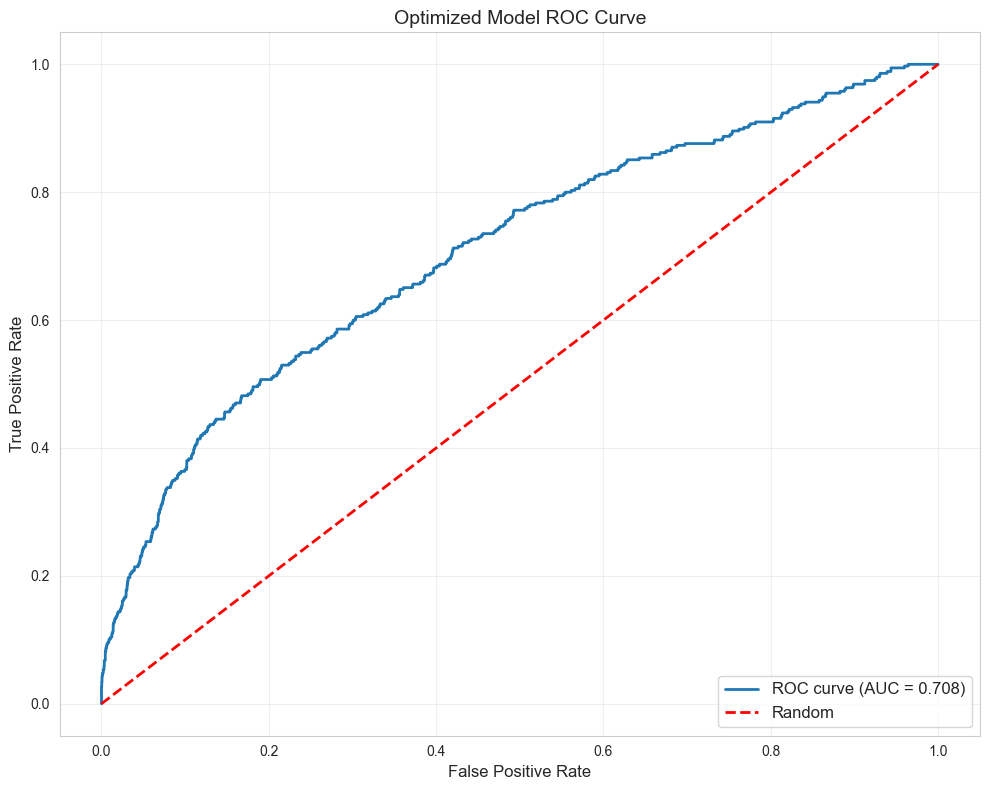

In [54]:
def train_optimized_model(params: Dict[str, Any], X_train: np.ndarray, y_train: np.ndarray) -> xgb.XGBClassifier:
    """Train model with optimized hyperparameters"""
    model = xgb.XGBClassifier(
        **params,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
        verbosity=0
    )
    
    # Simple fit without early stopping
    model.fit(X_train, y_train, verbose=False)
    
    return model

optimized_model = train_optimized_model(best_params, X_train, y_train)

# Evaluate optimized model
print("\n=== Optimized Model Results ===")
optimized_results = evaluate_model(optimized_model, X_test, y_test)
print("\nOptimized Results:")
print(optimized_results)
plot_roc_curve(optimized_model, X_test, y_test, "Optimized Model ROC Curve")


=== Cross-Validation on Optimized Model ===
Fold 1: AUC = 0.7118
Fold 2: AUC = 0.7052
Fold 3: AUC = 0.6834
Fold 4: AUC = 0.7044
Fold 5: AUC = 0.7291

Mean AUC: 0.7068 (+/- 0.0147)


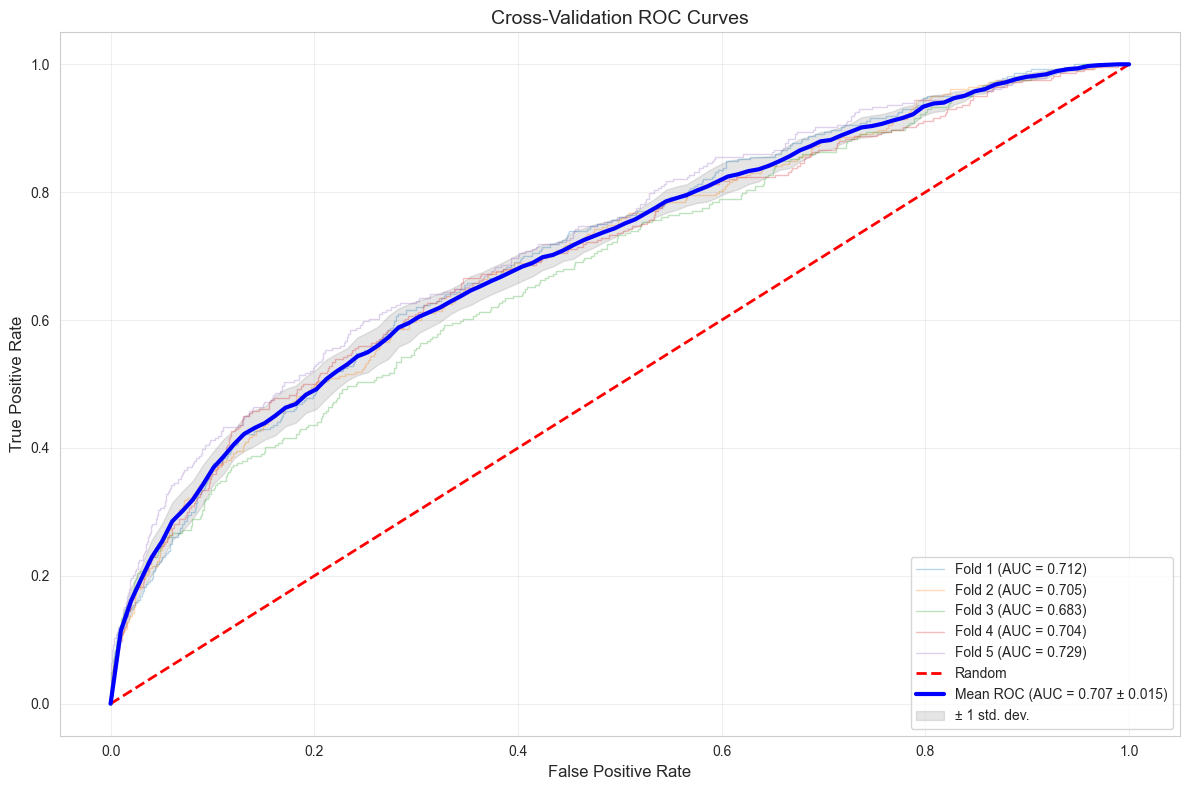

In [55]:
# Cross-validation on optimized model
print("\n=== Cross-Validation on Optimized Model ===")
fprs_opt, tprs_opt, aucs_opt = cross_validate_model(optimized_model, X_full, y_full, config.N_SPLITS)
plot_cv_roc_curves(fprs_opt, tprs_opt, aucs_opt)


OPTIMIZED MODEL - STRATIFIED K-FOLD CROSS-VALIDATION


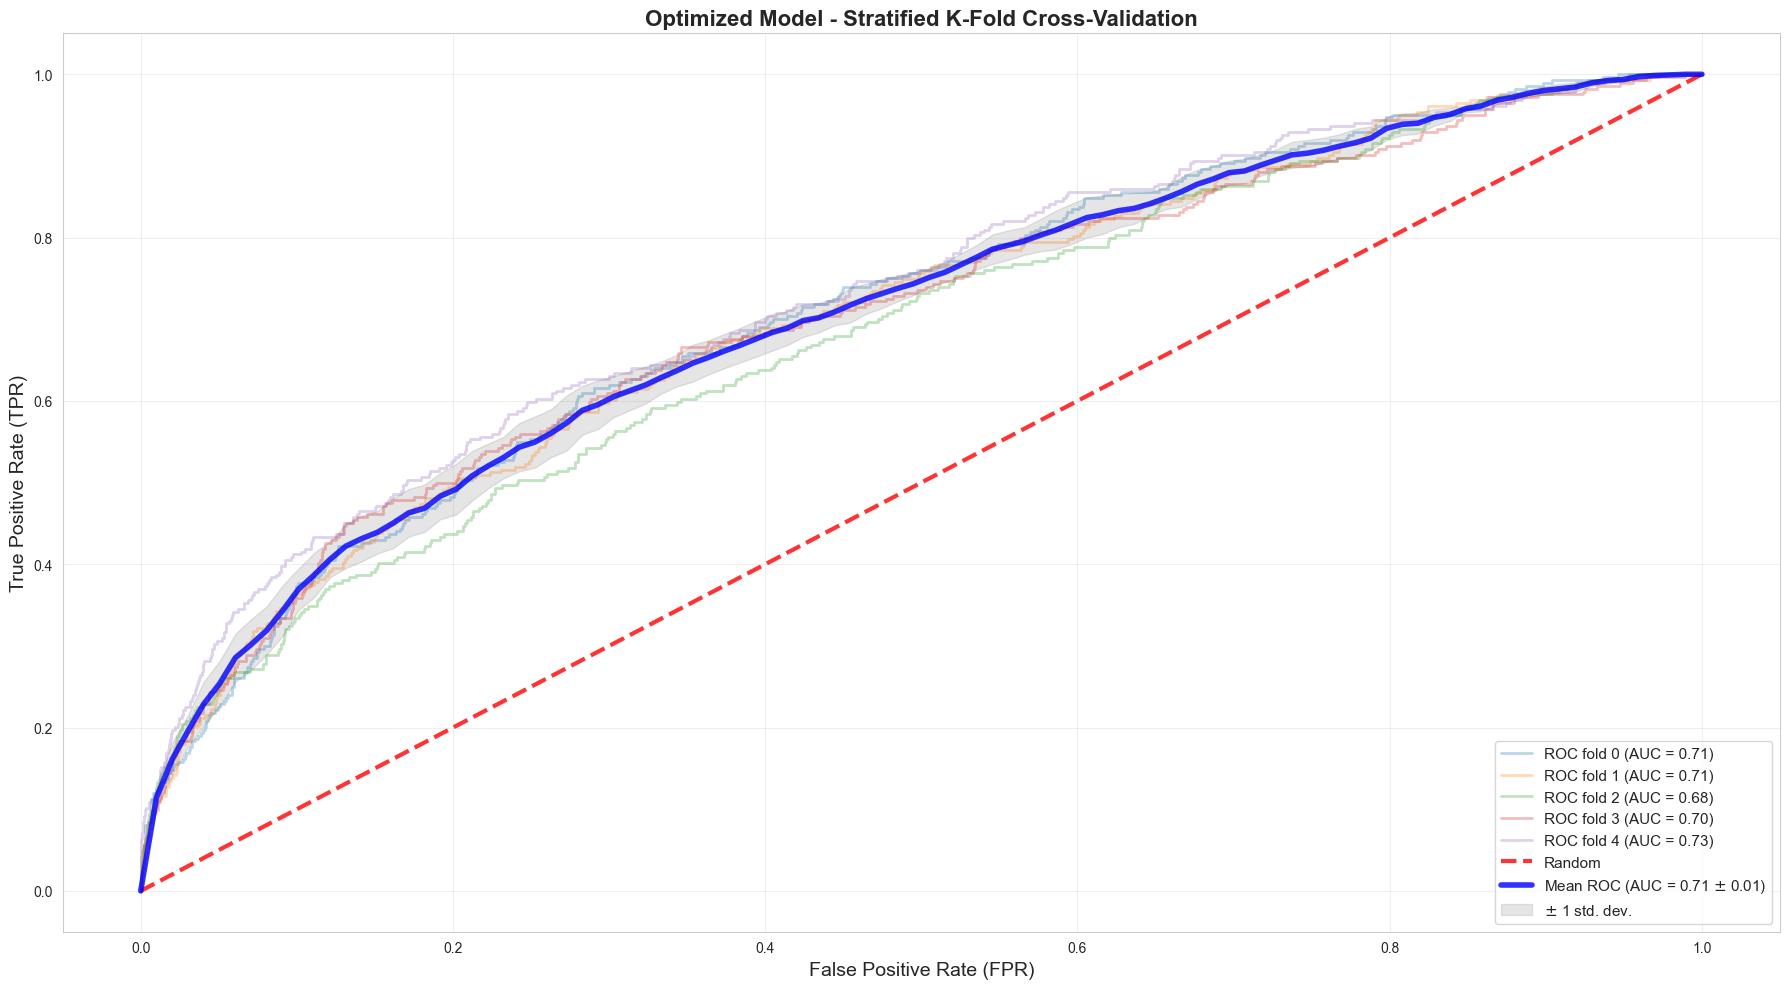


Mean AUC: 0.7068 ± 0.0147


In [56]:
# Enhanced CV visualization for optimized model
print("\n" + "="*60)
print("OPTIMIZED MODEL - STRATIFIED K-FOLD CROSS-VALIDATION")
print("="*60)
mean_auc_opt, std_auc_opt = plot_stratified_kfold_roc(
    fprs_opt, tprs_opt, aucs_opt,
    "Optimized Model - Stratified K-Fold Cross-Validation"
)
print(f"\nMean AUC: {mean_auc_opt:.4f} ± {std_auc_opt:.4f}")

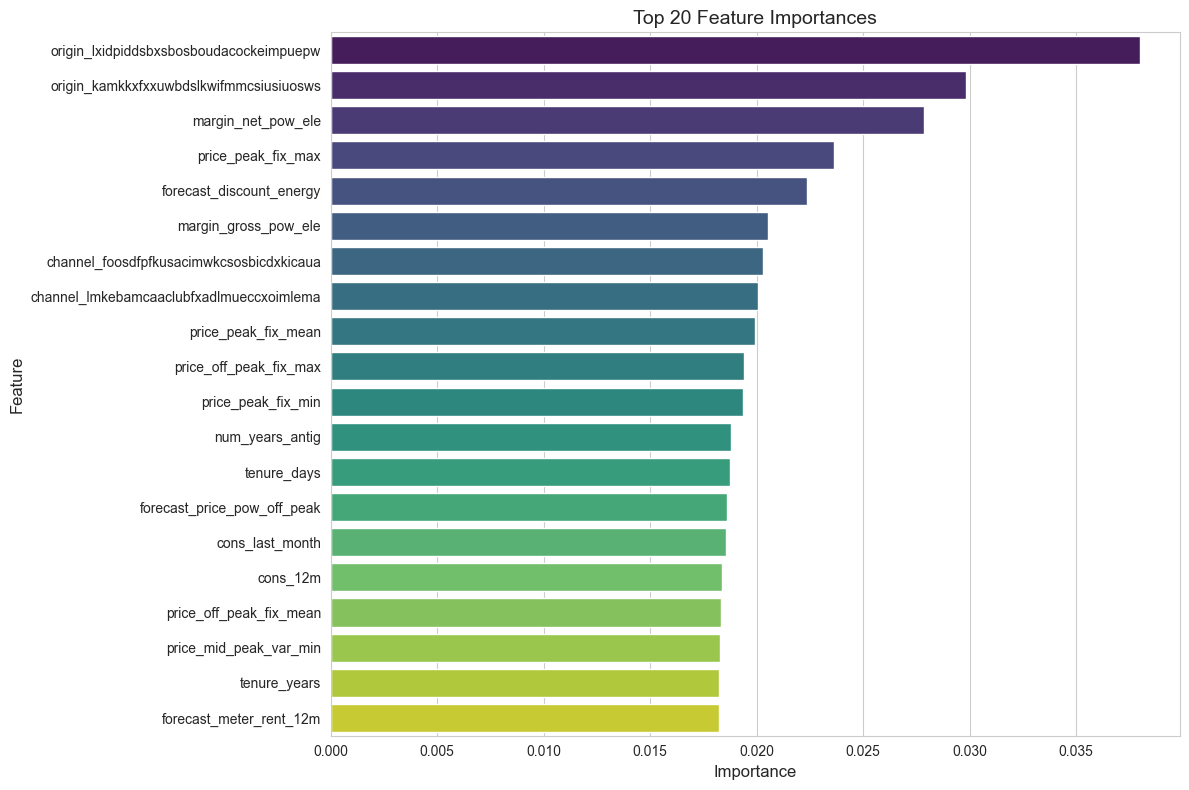


Top 10 Features:
                                     feature  importance
56   origin_lxidpiddsbxsbosboudacockeimpuepw    0.037985
54   origin_kamkkxfxxuwbdslkwifmmcsiusiuosws    0.029851
13                        margin_net_pow_ele    0.027877
37                        price_peak_fix_max    0.023623
5                   forecast_discount_energy    0.022354
12                      margin_gross_pow_ele    0.020554
49  channel_foosdfpfkusacimwkcsosbicdxkicaua    0.020277
50  channel_lmkebamcaaclubfxadlmueccxoimlema    0.020056
34                       price_peak_fix_mean    0.019934
33                    price_off_peak_fix_max    0.019413


In [57]:
def plot_feature_importance(model, feature_names: pd.Index, top_n: int = 20):
    """Plot feature importance"""
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=importance_df, y='feature', x='importance', palette='viridis')
    plt.title(f'Top {top_n} Feature Importances', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return importance_df

importance_df = plot_feature_importance(optimized_model, feature_names, top_n=20)
print("\nTop 10 Features:")
print(importance_df.head(10))


XGBOOST FEATURE IMPORTANCE (Built-in Visualization)


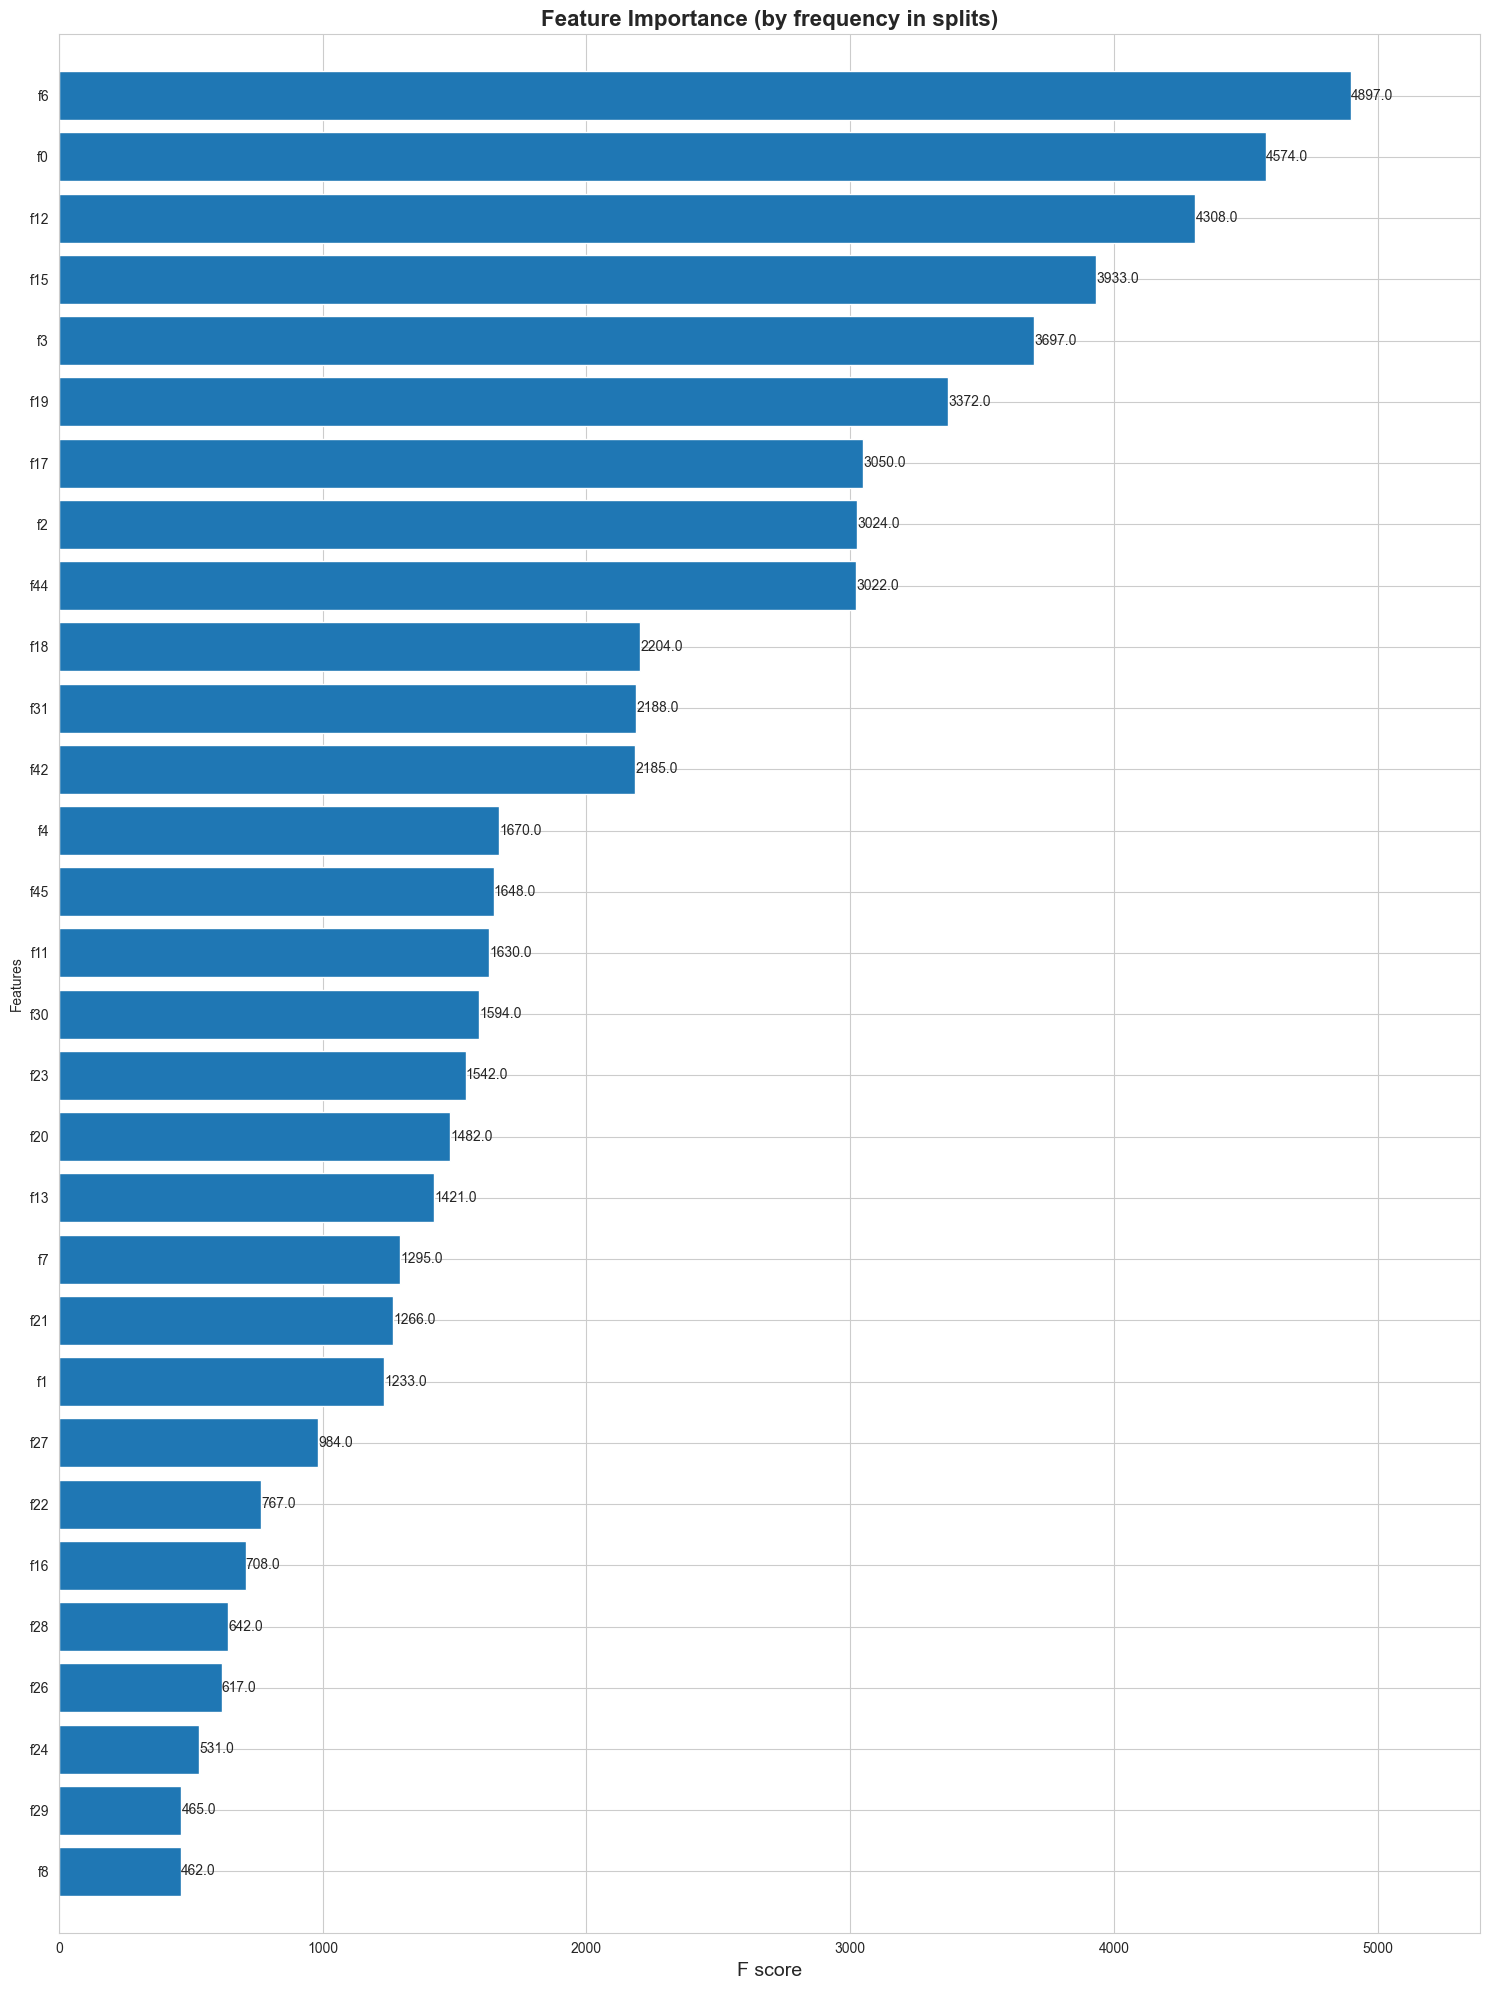

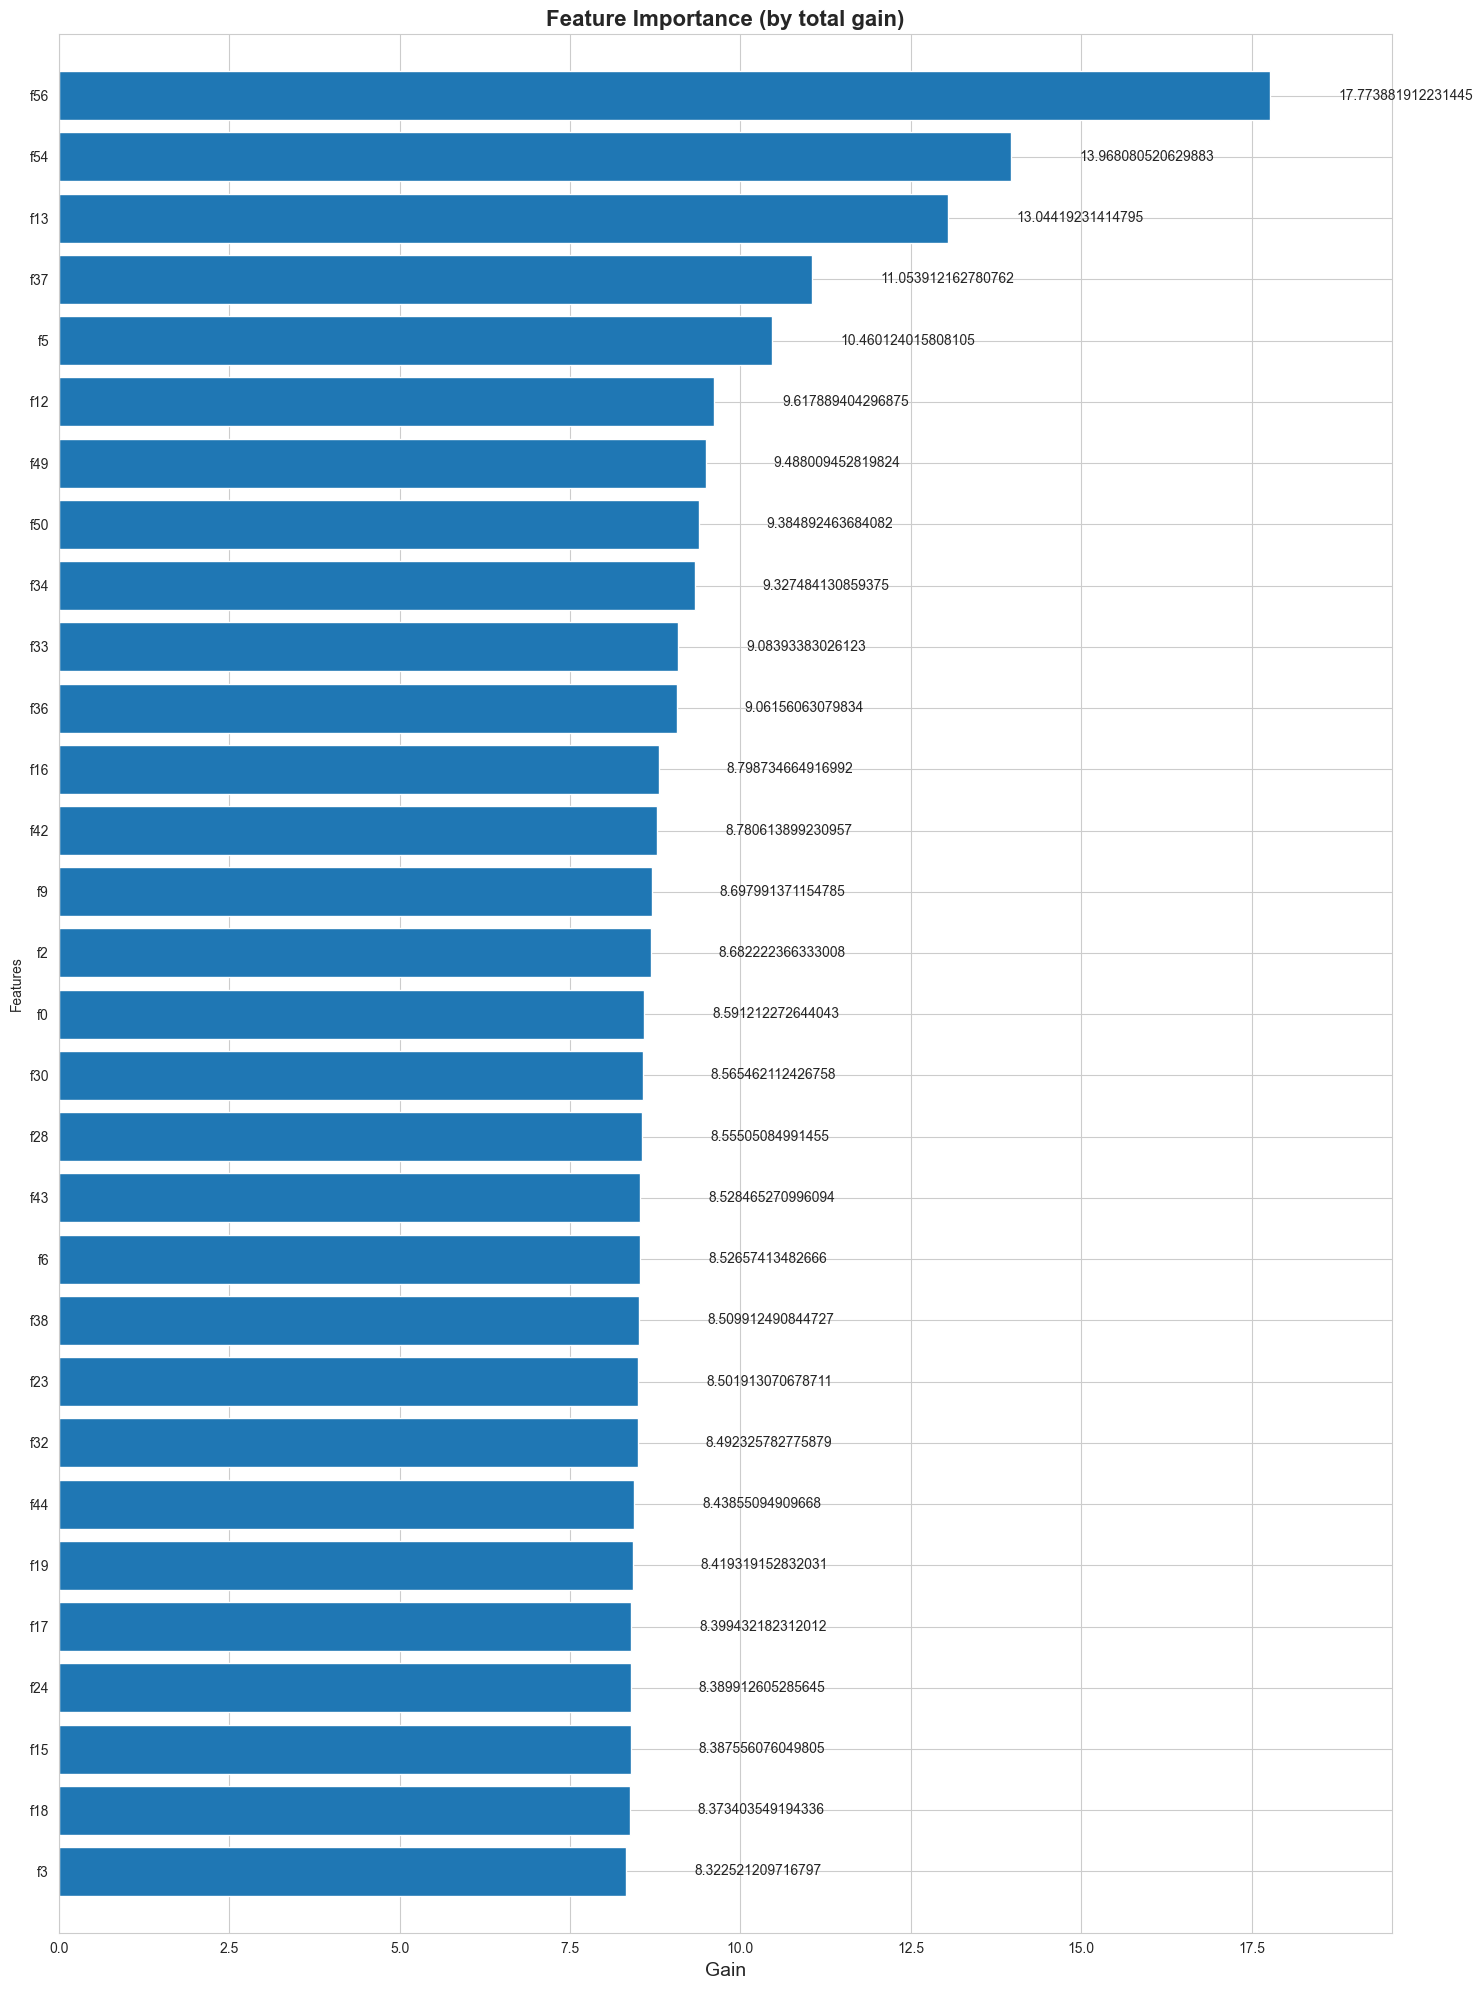

In [58]:
# XGBoost's built-in feature importance visualization
print("\n" + "="*60)
print("XGBOOST FEATURE IMPORTANCE (Built-in Visualization)")
print("="*60)

fig, ax = plt.subplots(figsize=(15, 20))
xgb.plot_importance(
    optimized_model, 
    ax=ax,
    height=0.8,
    max_num_features=30,
    importance_type='weight',  # 'weight', 'gain', or 'cover'
    show_values=True
)
plt.title('Feature Importance (by frequency in splits)', fontsize=16, fontweight='bold')
plt.xlabel('F score', fontsize=14)
plt.tight_layout()
plt.show()

# Alternative: Feature importance by gain
fig, ax = plt.subplots(figsize=(15, 20))
xgb.plot_importance(
    optimized_model, 
    ax=ax,
    height=0.8,
    max_num_features=30,
    importance_type='gain',
    show_values=True
)
plt.title('Feature Importance (by total gain)', fontsize=16, fontweight='bold')
plt.xlabel('Gain', fontsize=14)
plt.tight_layout()
plt.show()

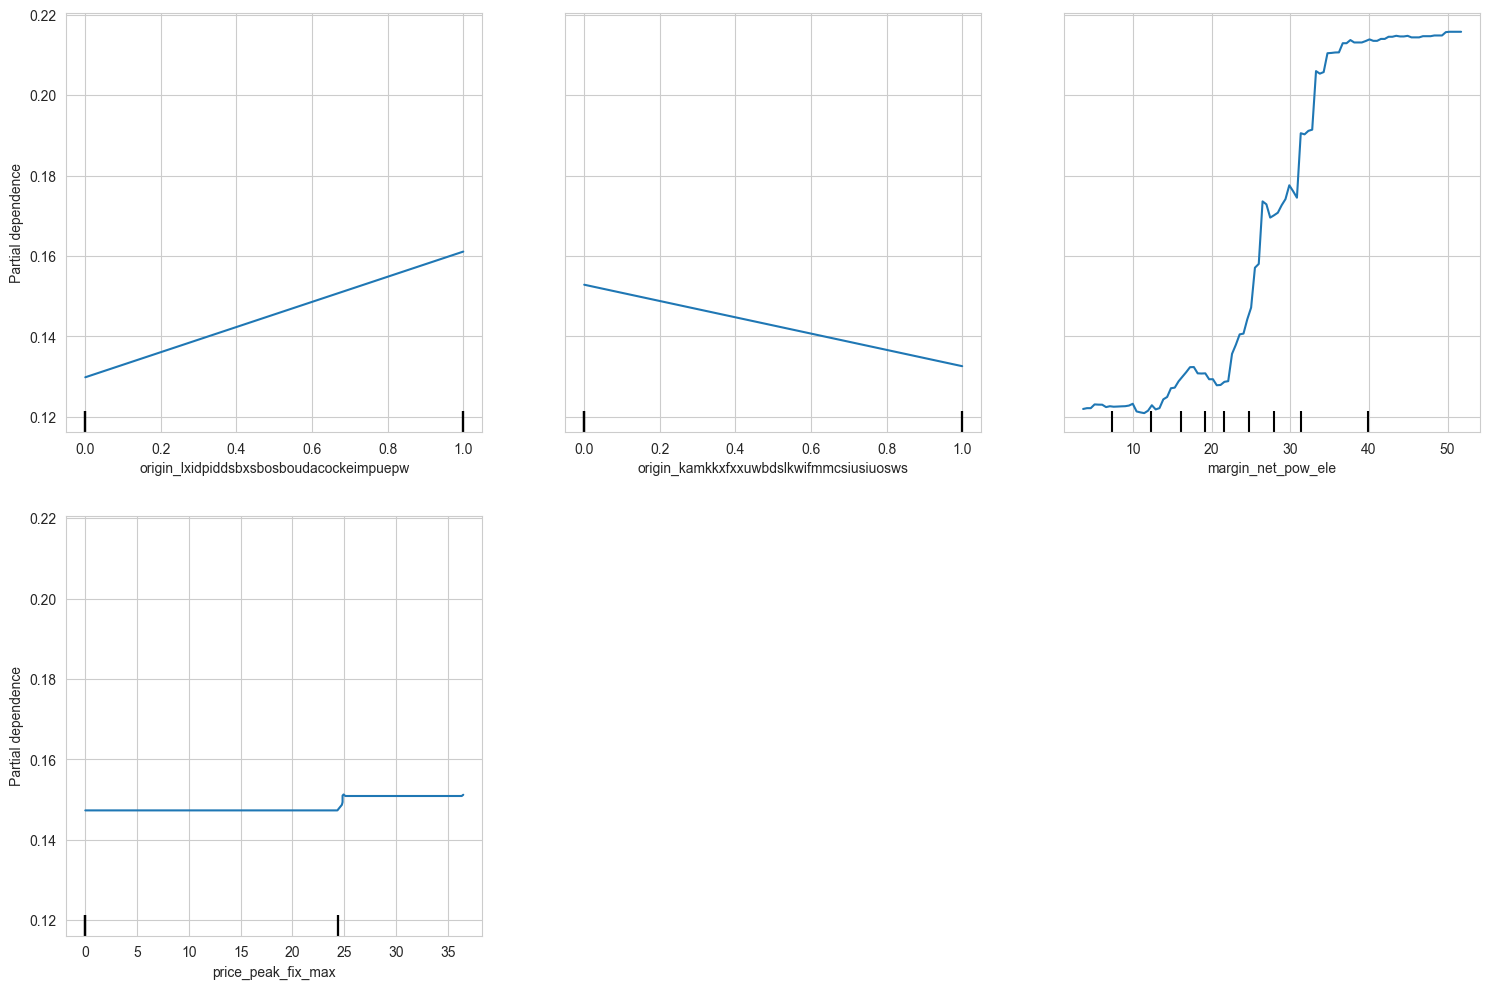

In [59]:
def plot_partial_dependence(model, X_test: np.ndarray, feature_names: pd.Index, features: List[int]):
    """Plot partial dependence for selected features"""
    fig, ax = plt.subplots(figsize=(15, 10))
    
    display = PartialDependenceDisplay.from_estimator(
        model, X_test, features=features,
        feature_names=feature_names.tolist(),
        ax=ax, n_jobs=-1
    )
    
    plt.tight_layout()
    plt.show()

# Plot PDP for top 4 features
top_features_idx = [list(feature_names).index(feat) for feat in importance_df.head(4)['feature']]
plot_partial_dependence(optimized_model, X_test, feature_names, top_features_idx)



PARTIAL DEPENDENCE PLOTS - TOP FEATURES


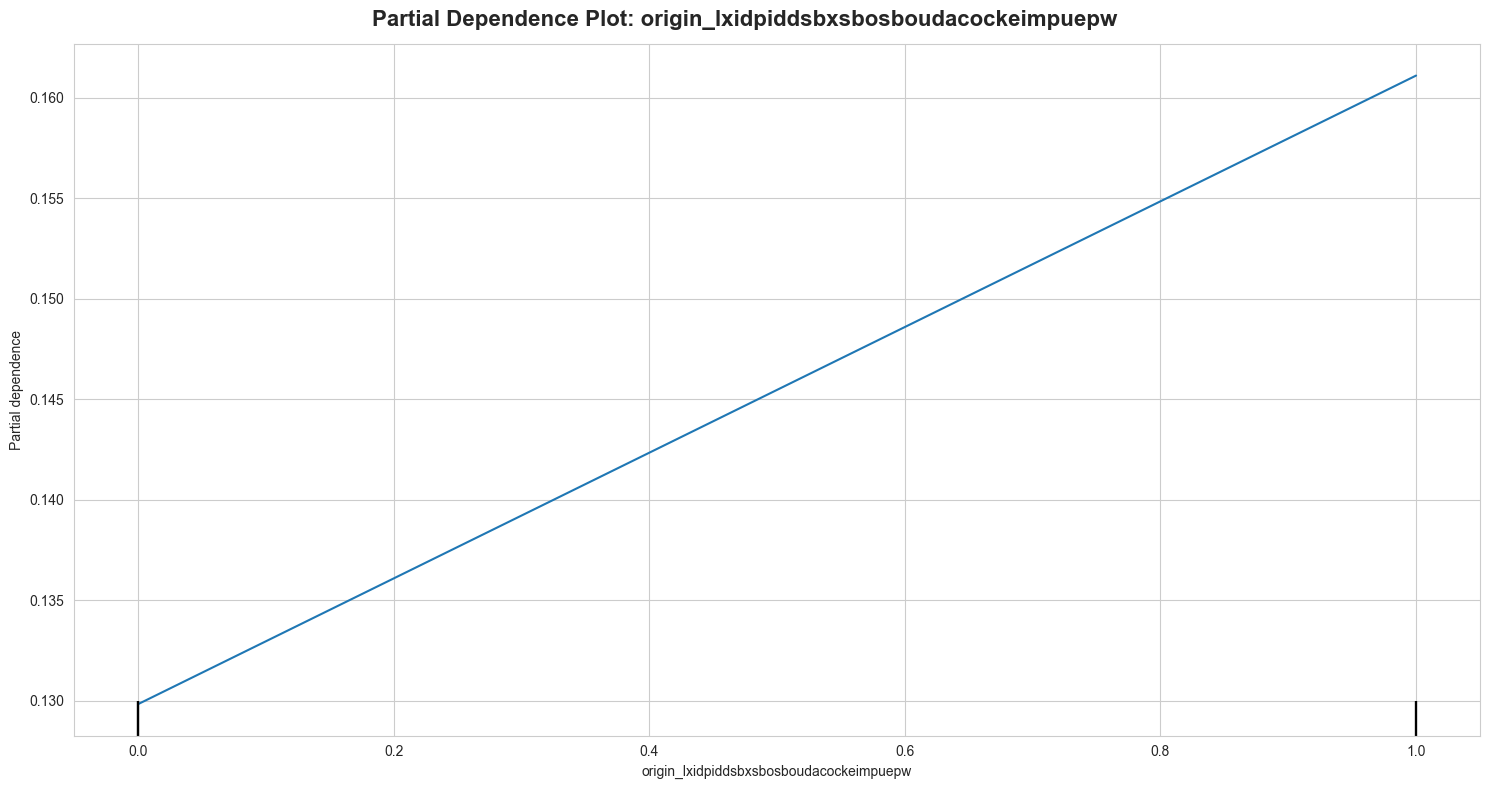

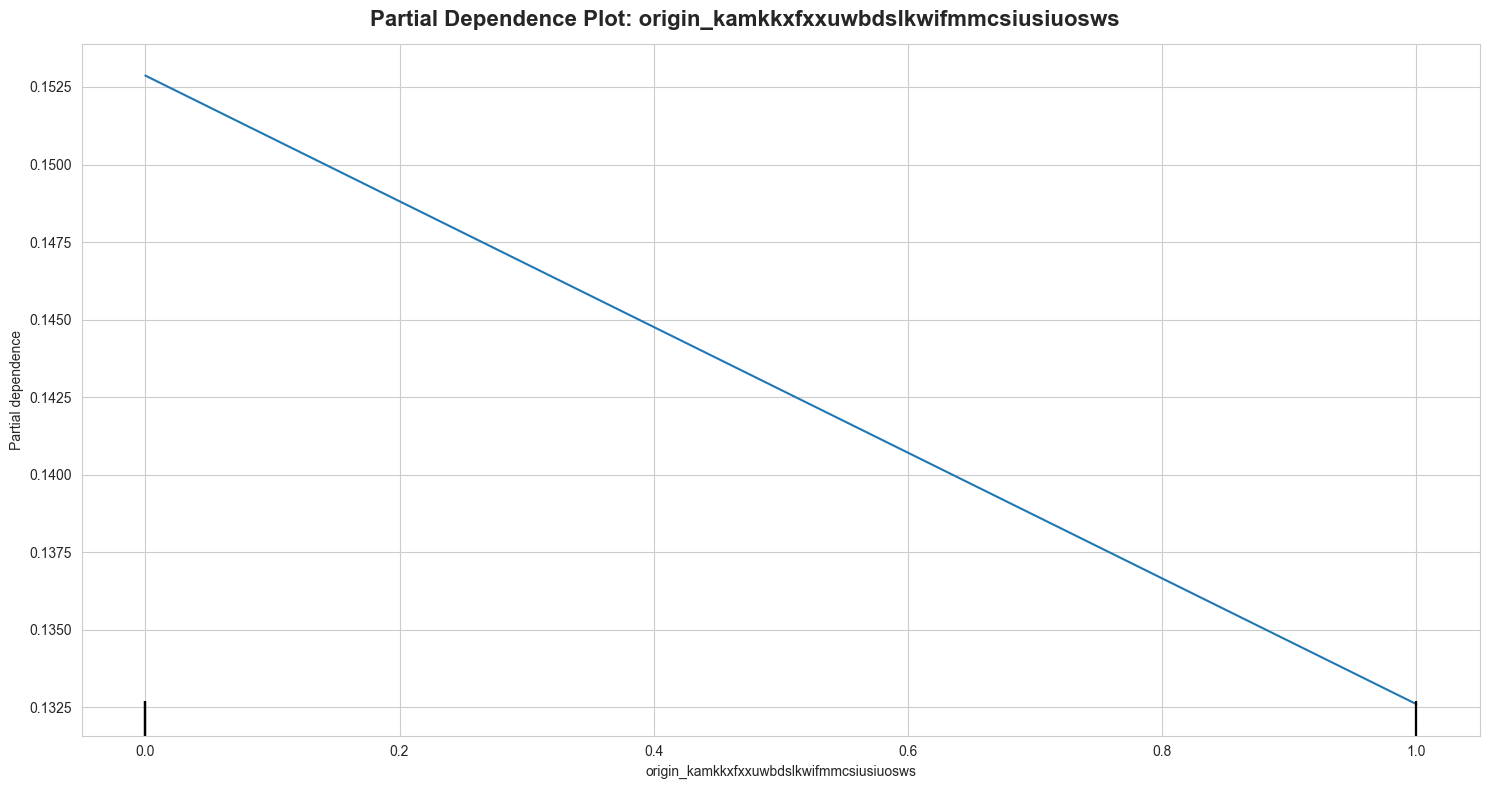

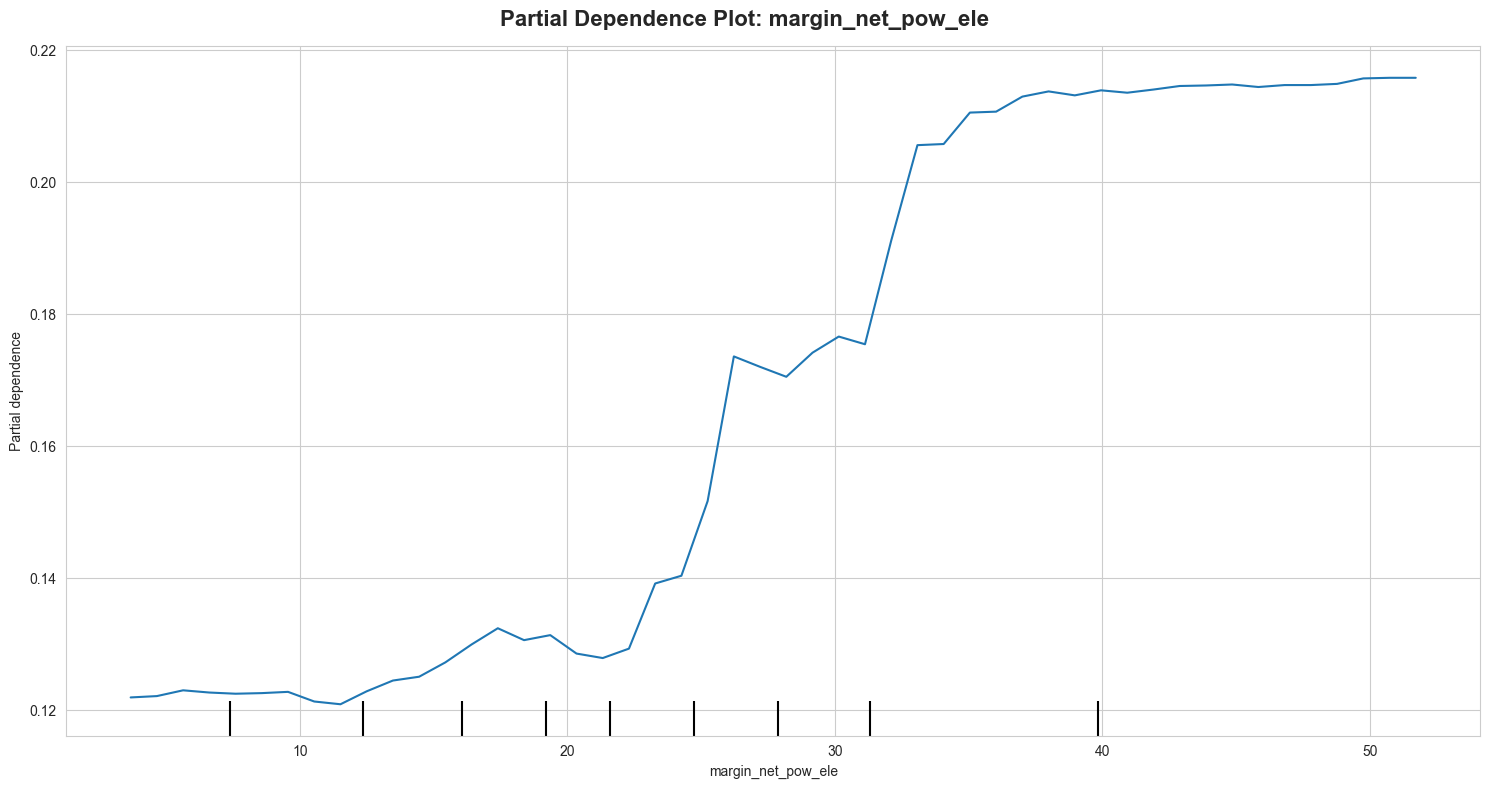

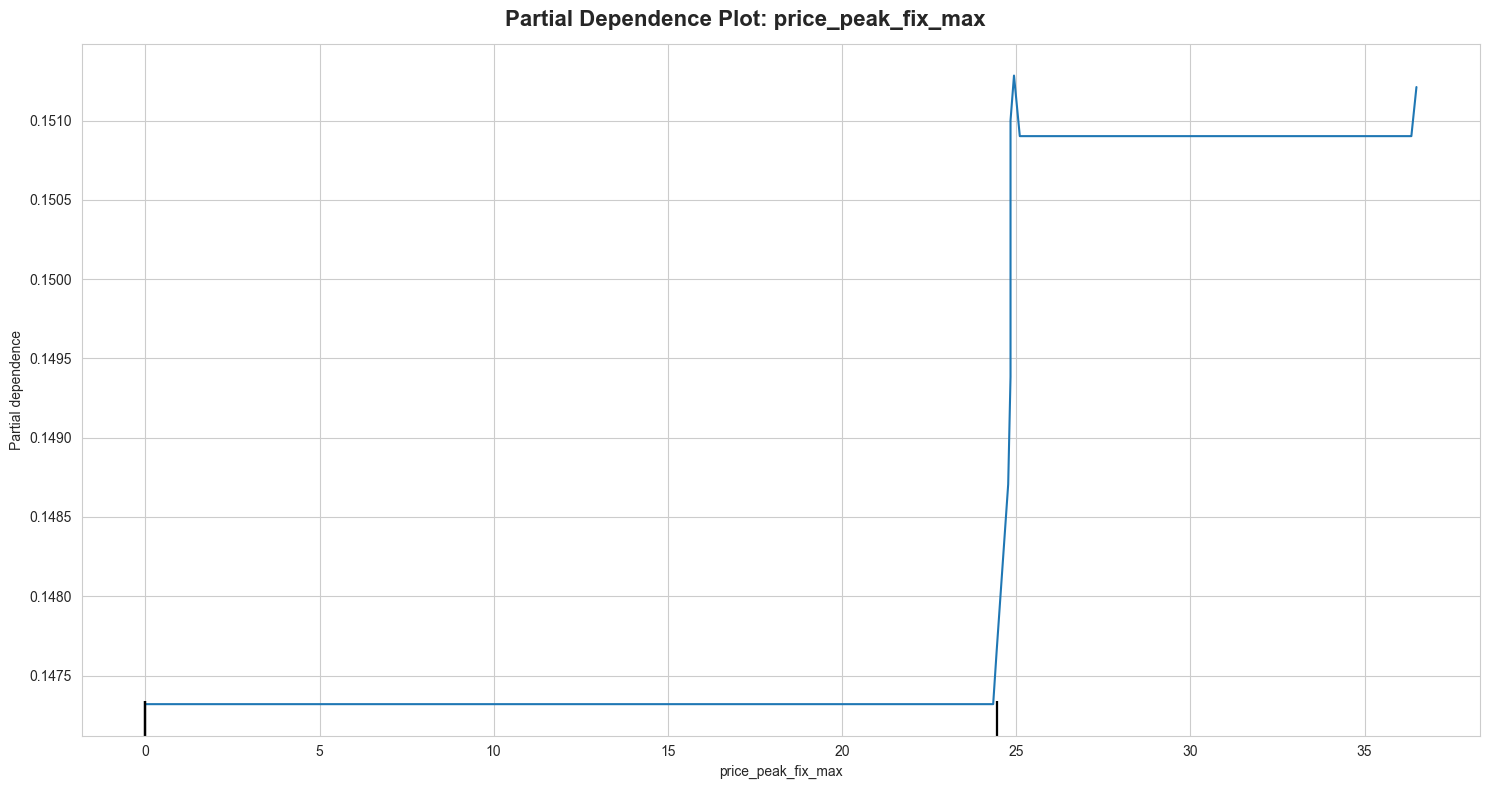

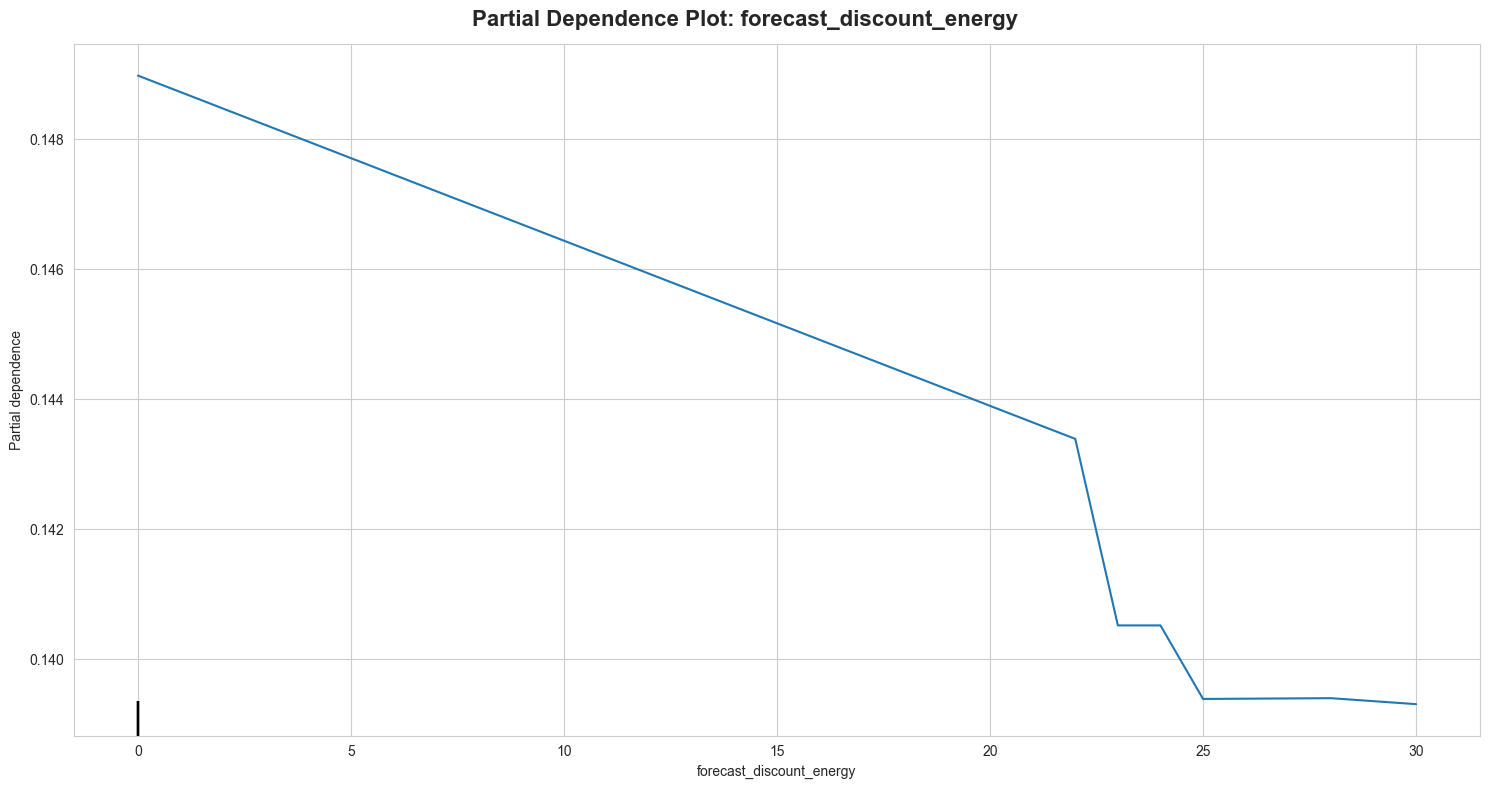

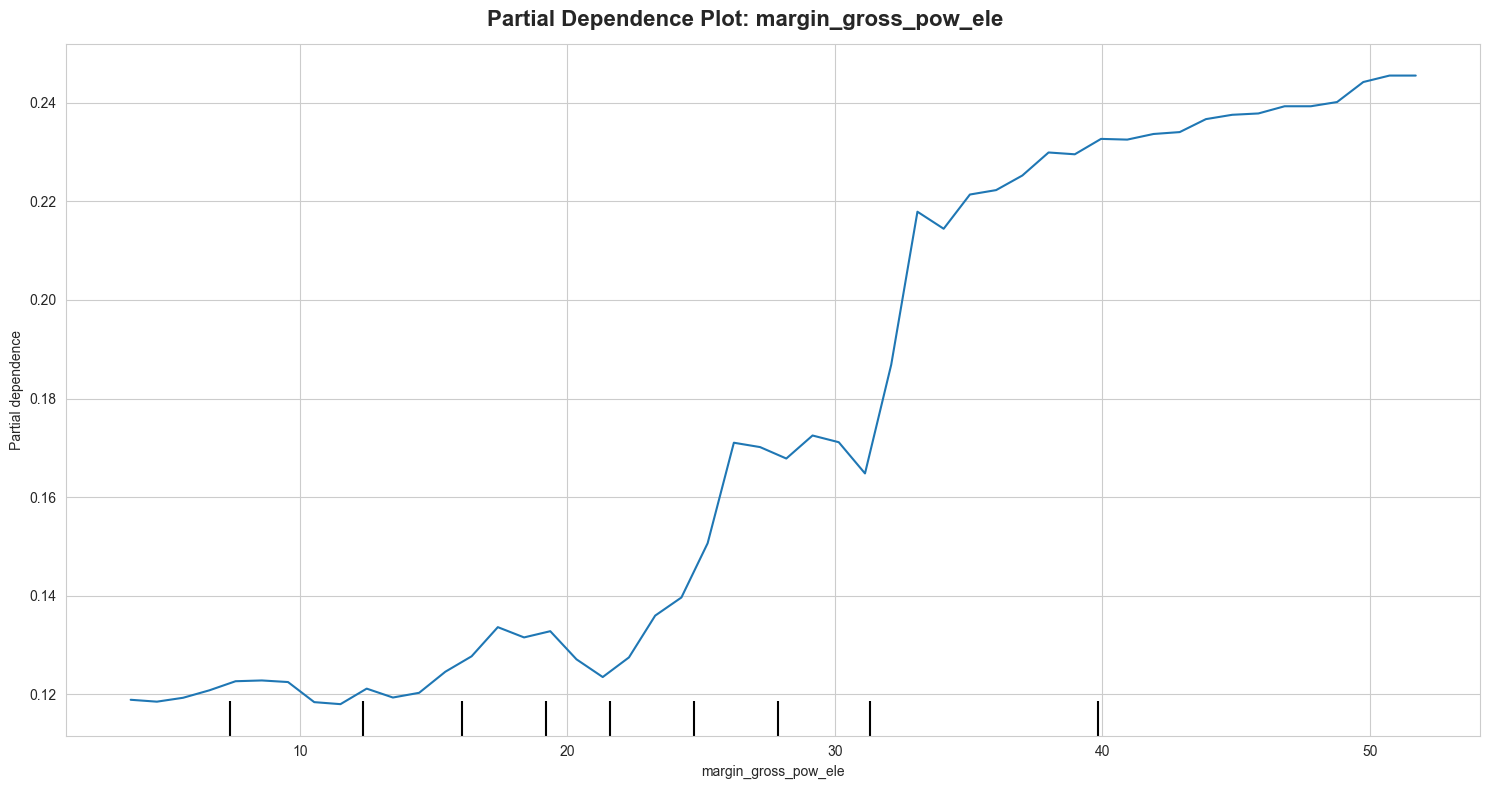

In [60]:
# More detailed PDP for individual features
def plot_individual_pdp(model, X_test, feature_names, feature_idx, feature_name):
    """Plot individual partial dependence plot"""
    fig, ax = plt.subplots(figsize=(15, 8))
    
    display = PartialDependenceDisplay.from_estimator(
        model, 
        X_test, 
        features=[feature_idx],
        feature_names=feature_names.tolist(),
        ax=ax,
        n_jobs=-1,
        grid_resolution=50
    )
    
    plt.suptitle(f'Partial Dependence Plot: {feature_name}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot PDP for top 6 features individually
print("\n" + "="*60)
print("PARTIAL DEPENDENCE PLOTS - TOP FEATURES")
print("="*60)

top_6_features = importance_df.head(6)['feature'].tolist()
for feat in top_6_features:
    feat_idx = list(feature_names).index(feat)
    plot_individual_pdp(optimized_model, X_test, feature_names, feat_idx, feat)

In [62]:
def analyze_with_shap(model, X_test: np.ndarray, feature_names: pd.Index, sample_size: int = 500):
    """Perform SHAP analysis with sampling for efficiency"""
    # Sample data for faster computation
    if len(X_test) > sample_size:
        sample_idx = np.random.choice(len(X_test), sample_size, replace=False)
        X_sample = X_test[sample_idx]
    else:
        X_sample = X_test
    
    # Create explainer and compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
    
    # Convert to DataFrame for easier handling
    X_sample_df = pd.DataFrame(X_sample, columns=feature_names)
    
    return explainer, shap_values, X_sample_df

explainer, shap_values, X_sample_df = analyze_with_shap(optimized_model, X_test, feature_names)

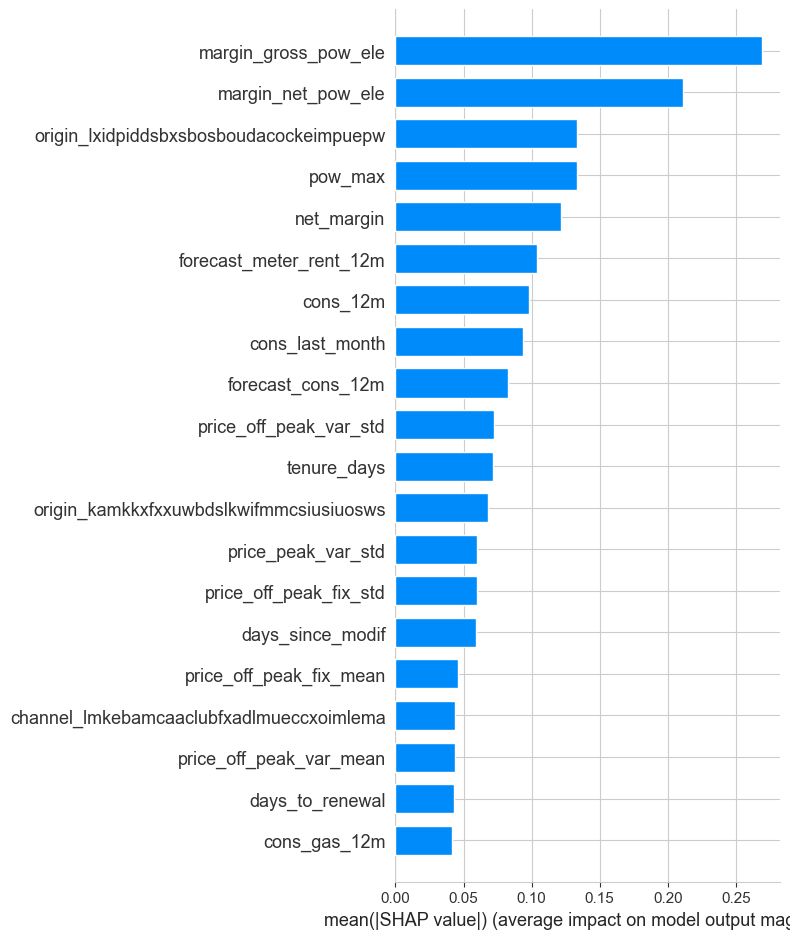

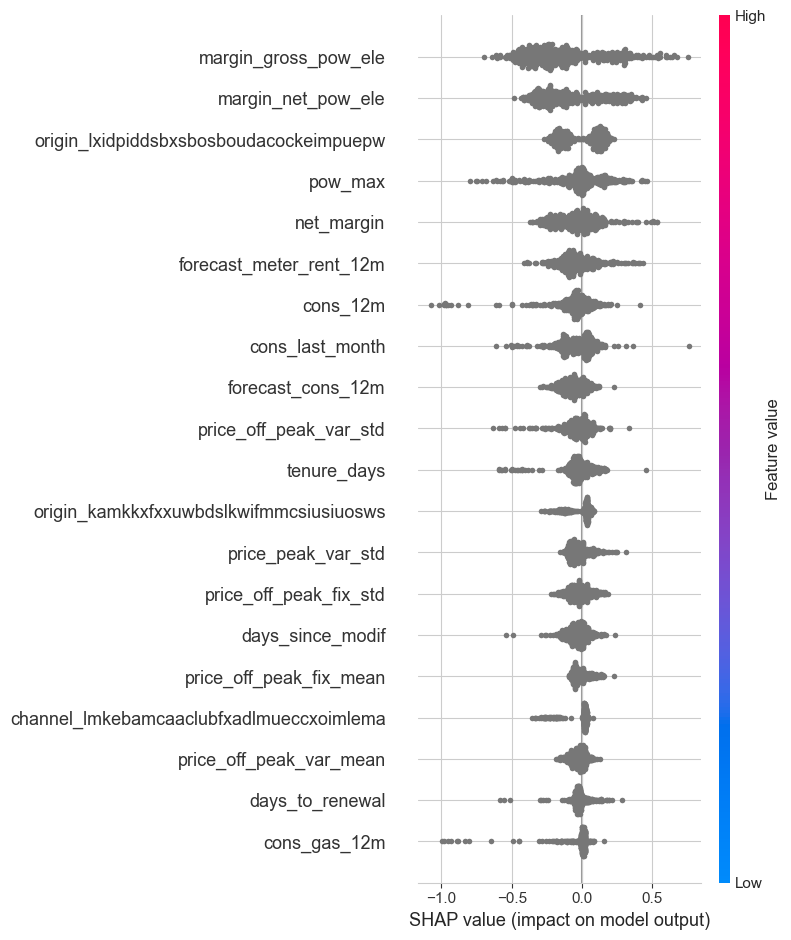

In [63]:
# SHAP summary plot - bar
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample_df, plot_type='bar', show=False)
plt.tight_layout()
plt.show()

# SHAP summary plot - detailed
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample_df, show=False)
plt.tight_layout()
plt.show()


SHAP WATERFALL PLOT - Single Prediction Explanation


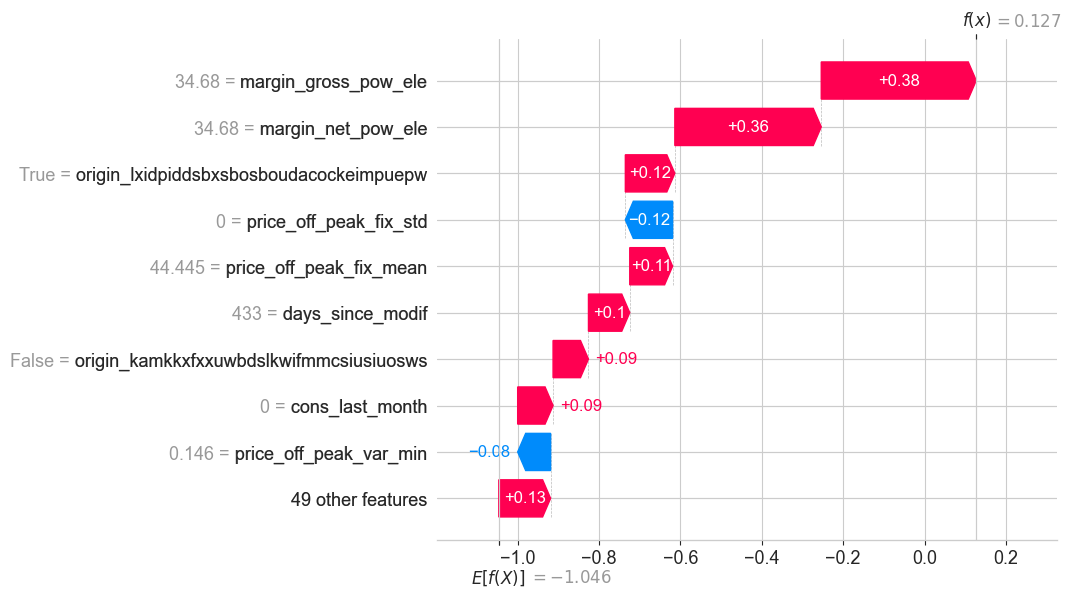


Predicted churn probability: 53.18%
Base value (average prediction): -1.0464


In [65]:
# SHAP waterfall plot for a single prediction
print("\n" + "="*60)
print("SHAP WATERFALL PLOT - Single Prediction Explanation")
print("="*60)

# Select an interesting prediction from the SAMPLED data
# (not from the full X_test, since SHAP was computed on a sample)
sample_proba = optimized_model.predict_proba(X_sample_df.values)[:, 1]
high_churn_sample_idx = np.argsort(sample_proba)[-5]  # 5th highest in the sample

shap.plots.waterfall(shap.Explanation(
    values=shap_values[high_churn_sample_idx],
    base_values=explainer.expected_value,
    data=X_sample_df.iloc[high_churn_sample_idx],
    feature_names=feature_names.tolist()
))

print(f"\nPredicted churn probability: {sample_proba[high_churn_sample_idx]:.2%}")
print(f"Base value (average prediction): {explainer.expected_value:.4f}")

<Figure size 1000x600 with 0 Axes>

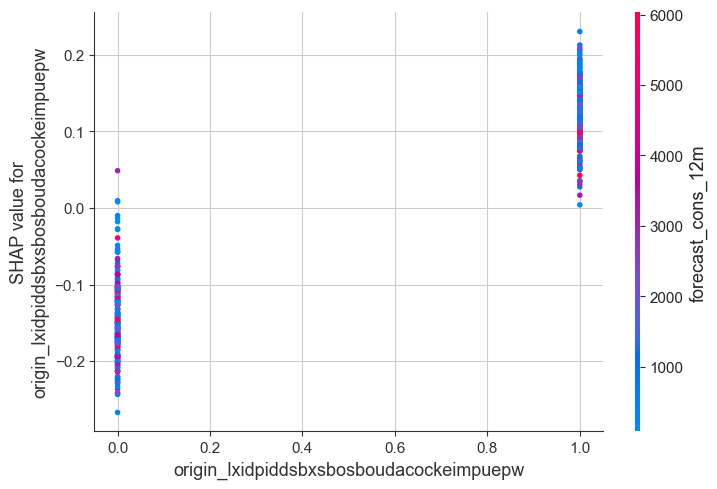

In [66]:
# SHAP dependence plot for top feature
top_feature = importance_df.iloc[0]['feature']
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    top_feature, 
    shap_values, 
    X_sample_df,
    show=False
)
plt.tight_layout()
plt.show()


SHAP BEESWARM PLOT - Feature Impact Distribution


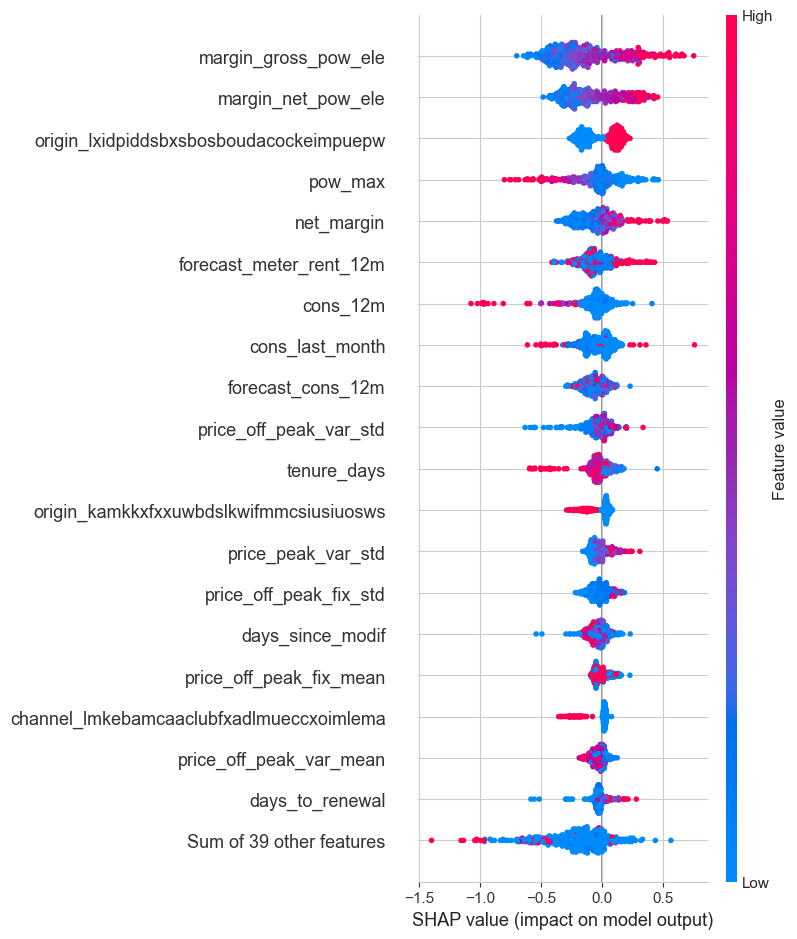

In [67]:
# SHAP beeswarm plot (colored by feature value)
print("\n" + "="*60)
print("SHAP BEESWARM PLOT - Feature Impact Distribution")
print("="*60)

plt.figure(figsize=(14, 10))
shap.plots.beeswarm(shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_sample_df.values,
    feature_names=feature_names.tolist()
), show=False, max_display=20)
plt.tight_layout()
plt.show()

In [68]:
# SHAP force plot for single prediction
sample_idx = 0
shap.initjs()
shap.force_plot(
    explainer.expected_value, 
    shap_values[sample_idx], 
    X_sample_df.iloc[sample_idx, :]
)


=== Model Comparison ===
       Model  Accuracy  Precision    Recall   ROC-AUC
0   Baseline  0.901424   0.462687  0.087324  0.678510
1  Optimized  0.903888   0.529412  0.101408  0.707648


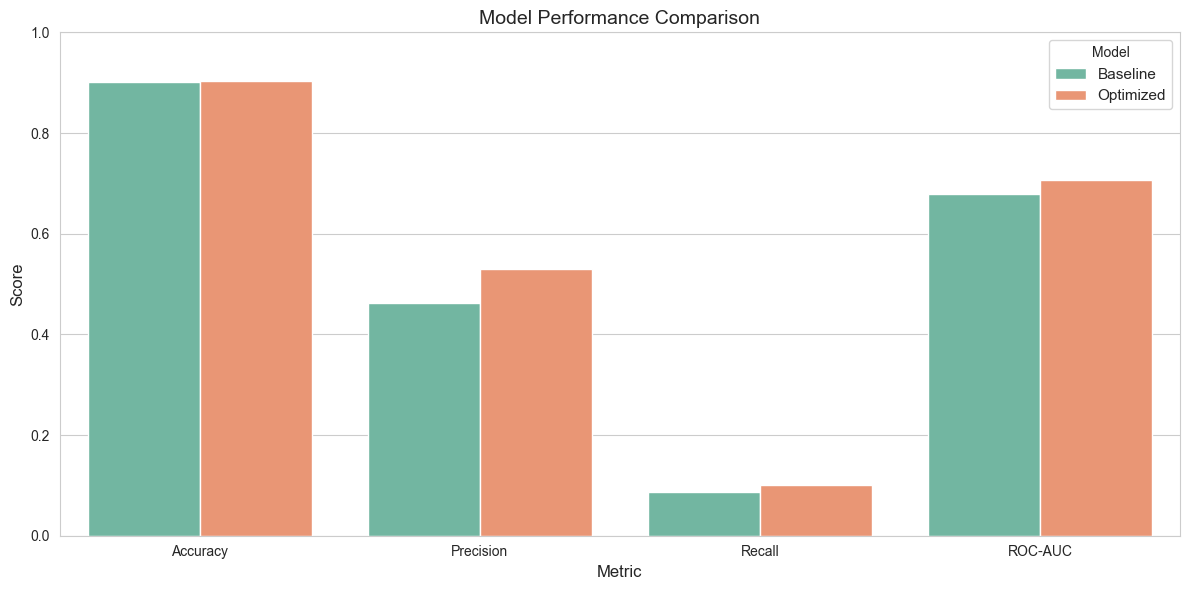

In [69]:
# Compare baseline vs optimized
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Optimized'],
    'Accuracy': [
        accuracy_score(y_test, baseline_model.predict(X_test)),
        accuracy_score(y_test, optimized_model.predict(X_test))
    ],
    'Precision': [
        precision_score(y_test, baseline_model.predict(X_test)),
        precision_score(y_test, optimized_model.predict(X_test))
    ],
    'Recall': [
        recall_score(y_test, baseline_model.predict(X_test)),
        recall_score(y_test, optimized_model.predict(X_test))
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, baseline_model.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, optimized_model.predict_proba(X_test)[:, 1])
    ]
})

print("\n=== Model Comparison ===")
print(comparison_df)

# Visualize comparison
comparison_melted = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_melted, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title('Model Performance Comparison', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.legend(title='Model', fontsize=11)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


CONFUSION MATRICES - Baseline vs Optimized


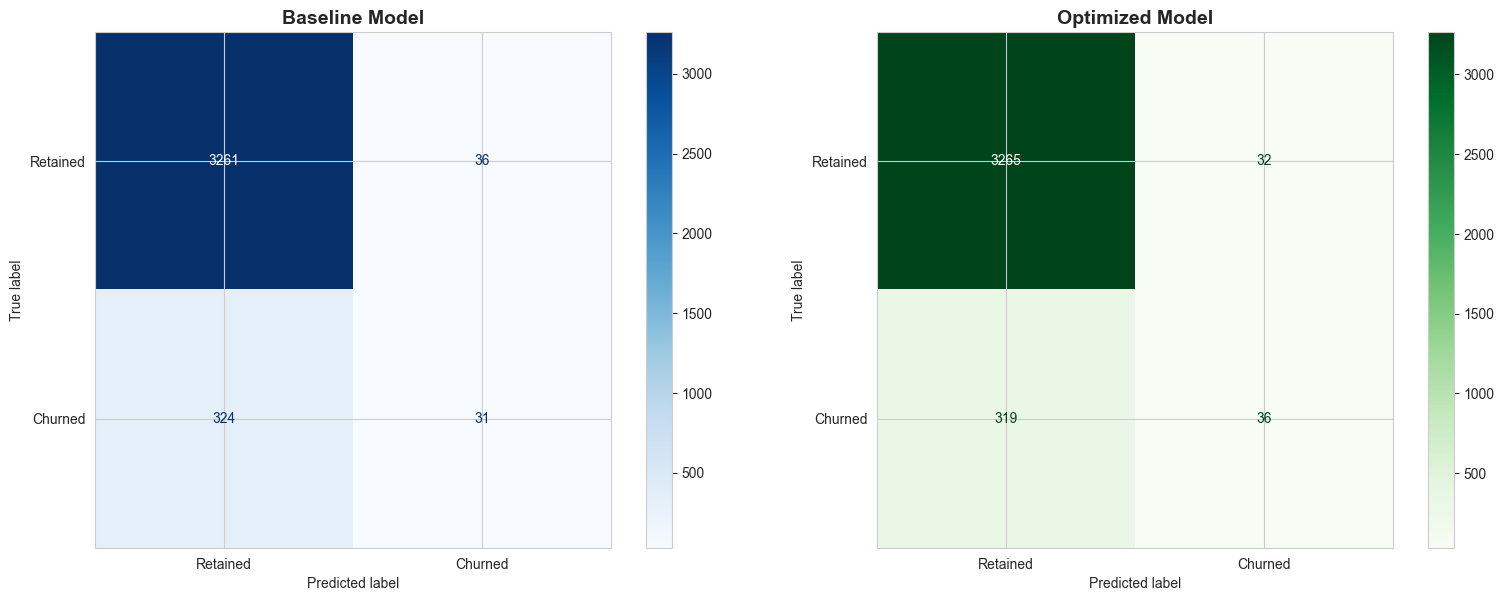

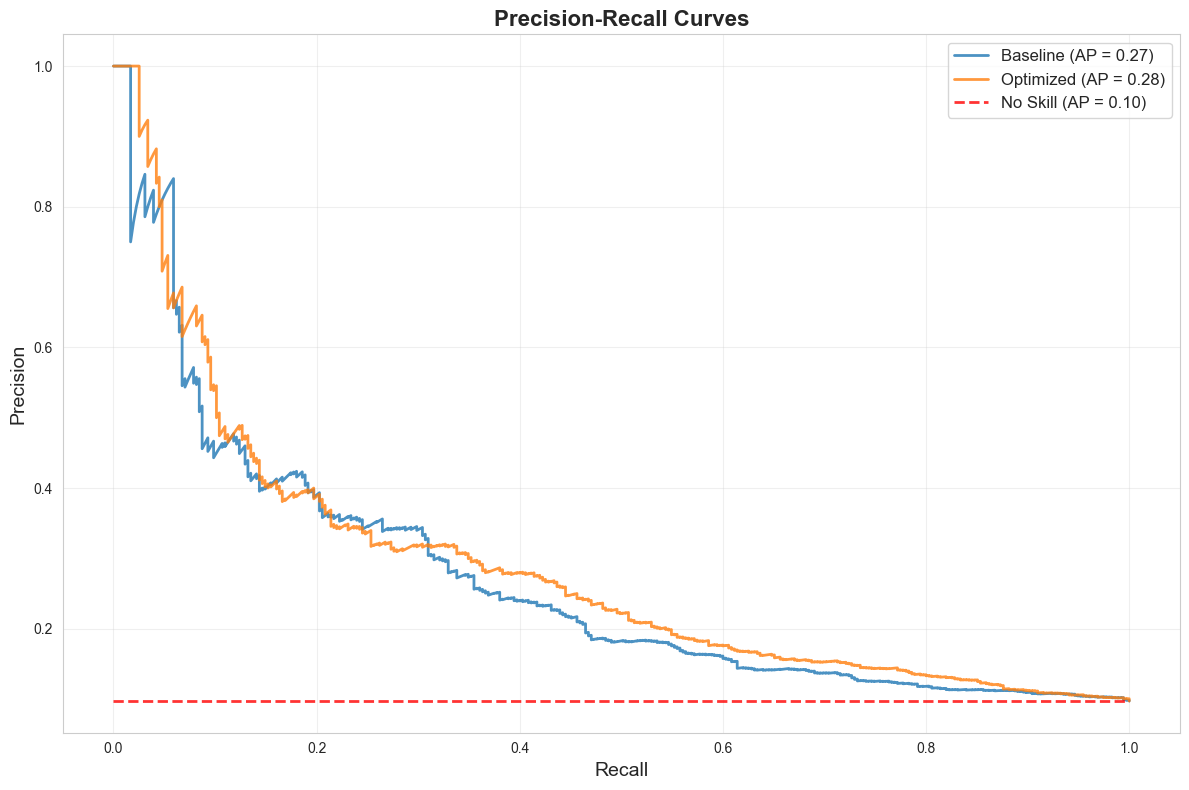

In [70]:
# Additional comparison: Confusion matrices side by side
print("\n" + "="*60)
print("CONFUSION MATRICES - Baseline vs Optimized")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Baseline confusion matrix
y_pred_baseline = baseline_model.predict(X_test)
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, 
                                display_labels=['Retained', 'Churned'])
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Baseline Model', fontsize=14, fontweight='bold')

# Optimized confusion matrix
y_pred_optimized = optimized_model.predict(X_test)
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_optimized,
                                display_labels=['Retained', 'Churned'])
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('Optimized Model', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Precision-Recall curves
fig, ax = plt.subplots(figsize=(12, 8))

# Baseline PR curve
y_pred_proba_base = baseline_model.predict_proba(X_test)[:, 1]
precision_base, recall_base, _ = precision_recall_curve(y_test, y_pred_proba_base)
ap_base = average_precision_score(y_test, y_pred_proba_base)
ax.plot(recall_base, precision_base, lw=2, 
        label=f'Baseline (AP = {ap_base:.2f})', alpha=0.8)

# Optimized PR curve
y_pred_proba_opt = optimized_model.predict_proba(X_test)[:, 1]
precision_opt, recall_opt, _ = precision_recall_curve(y_test, y_pred_proba_opt)
ap_opt = average_precision_score(y_test, y_pred_proba_opt)
ax.plot(recall_opt, precision_opt, lw=2,
        label=f'Optimized (AP = {ap_opt:.2f})', alpha=0.8)

# No-skill line
no_skill = y_test.mean()
ax.plot([0, 1], [no_skill, no_skill], linestyle='--', lw=2, 
        color='red', label=f'No Skill (AP = {no_skill:.2f})', alpha=0.8)

ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.set_title('Precision-Recall Curves', fontsize=16, fontweight='bold')
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [72]:
def save_model(model, feature_names: pd.Index, params: Dict[str, Any], save_dir: str = "models"):
    """Save trained model and metadata"""
    save_path = Path(save_dir)
    save_path.mkdir(exist_ok=True)
    
    # Save model using pickle (more compatible)
    model_path = save_path / "optimized_xgboost_model.pkl"
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    
    # Save metadata
    metadata = {
        'feature_names': feature_names.tolist(),
        'best_params': params,
        'n_features': len(feature_names)
    }
    
    metadata_path = save_path / "model_metadata.pkl"
    with open(metadata_path, 'wb') as f:
        pickle.dump(metadata, f)
    
    print(f"✓ Model saved to {model_path}")
    print(f"✓ Metadata saved to {metadata_path}")
    
    # Also save as JSON if possible (fallback)
    try:
        json_path = save_path / "optimized_xgboost_model.json"
        model.get_booster().save_model(str(json_path))
        print(f"✓ Booster saved to {json_path}")
    except Exception as e:
        print(f"⚠ Could not save JSON format: {e}")

# Save the optimized model
save_model(optimized_model, feature_names, best_params)

print("\n" + "="*60)
print("Model saved successfully!")
print("="*60)

✓ Model saved to models\optimized_xgboost_model.pkl
✓ Metadata saved to models\model_metadata.pkl
✓ Booster saved to models\optimized_xgboost_model.json

Model saved successfully!



                    FINAL MODEL SUMMARY DASHBOARD

✓ Dashboard saved as 'model_dashboard.png'


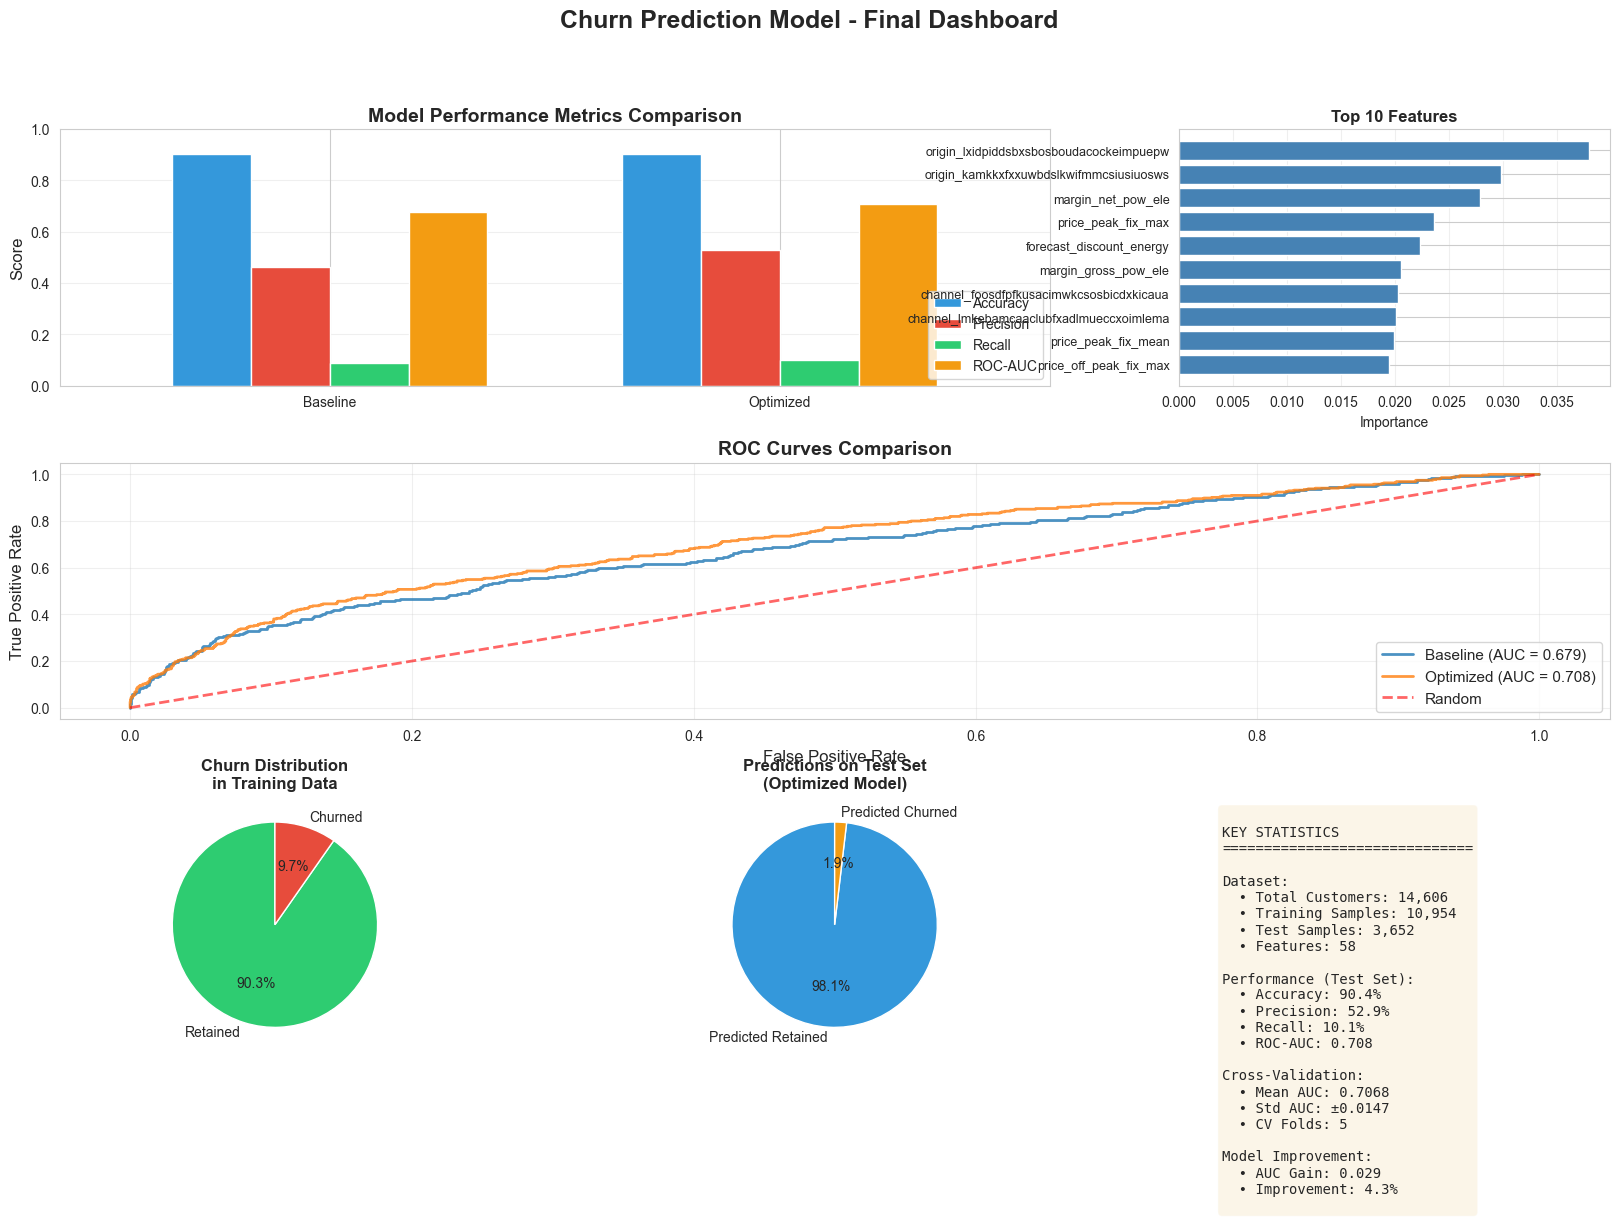


Analysis Complete! All visualizations generated.


In [73]:
# Create a comprehensive summary dashboard
print("\n" + "="*70)
print(" " * 20 + "FINAL MODEL SUMMARY DASHBOARD")
print("="*70)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Metrics comparison bar plot
ax1 = fig.add_subplot(gs[0, :2])
metrics_comparison = comparison_df.set_index('Model')
metrics_comparison.plot(kind='bar', ax=ax1, width=0.7, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
ax1.set_title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12)
ax1.set_xlabel('')
ax1.legend(loc='lower right', fontsize=10)
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)

# 2. Feature importance (top 10)
ax2 = fig.add_subplot(gs[0, 2])
top_10_features = importance_df.head(10)
ax2.barh(range(len(top_10_features)), top_10_features['importance'], color='steelblue')
ax2.set_yticks(range(len(top_10_features)))
ax2.set_yticklabels(top_10_features['feature'], fontsize=9)
ax2.set_xlabel('Importance', fontsize=10)
ax2.set_title('Top 10 Features', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 3. ROC curves comparison
ax3 = fig.add_subplot(gs[1, :])
# Baseline
fpr_b, tpr_b, _ = roc_curve(y_test, baseline_model.predict_proba(X_test)[:, 1])
auc_b = auc(fpr_b, tpr_b)
ax3.plot(fpr_b, tpr_b, lw=2, label=f'Baseline (AUC = {auc_b:.3f})', alpha=0.8)

# Optimized
fpr_o, tpr_o, _ = roc_curve(y_test, optimized_model.predict_proba(X_test)[:, 1])
auc_o = auc(fpr_o, tpr_o)
ax3.plot(fpr_o, tpr_o, lw=2, label=f'Optimized (AUC = {auc_o:.3f})', alpha=0.8)

# Random
ax3.plot([0, 1], [0, 1], 'r--', lw=2, label='Random', alpha=0.6)
ax3.set_xlabel('False Positive Rate', fontsize=12)
ax3.set_ylabel('True Positive Rate', fontsize=12)
ax3.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax3.legend(loc='lower right', fontsize=11)
ax3.grid(True, alpha=0.3)

# 4. Churn distribution
ax4 = fig.add_subplot(gs[2, 0])
churn_counts = train[config.TARGET_COL].value_counts()
ax4.pie(churn_counts, labels=['Retained', 'Churned'], autopct='%1.1f%%',
        colors=['#2ecc71', '#e74c3c'], startangle=90)
ax4.set_title('Churn Distribution\nin Training Data', fontsize=12, fontweight='bold')

# 5. Prediction distribution
ax5 = fig.add_subplot(gs[2, 1])
predictions = optimized_model.predict(X_test)
pred_counts = pd.Series(predictions).value_counts()
ax5.pie(pred_counts, labels=['Predicted Retained', 'Predicted Churned'], 
        autopct='%1.1f%%', colors=['#3498db', '#f39c12'], startangle=90)
ax5.set_title('Predictions on Test Set\n(Optimized Model)', fontsize=12, fontweight='bold')

# 6. Key statistics
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')

stats_text = f"""
KEY STATISTICS
{'='*30}

Dataset:
  • Total Customers: {len(train):,}
  • Training Samples: {len(X_train):,}
  • Test Samples: {len(X_test):,}
  • Features: {X_train.shape[1]}

Performance (Test Set):
  • Accuracy: {accuracy_score(y_test, predictions):.1%}
  • Precision: {precision_score(y_test, predictions):.1%}
  • Recall: {recall_score(y_test, predictions):.1%}
  • ROC-AUC: {auc_o:.3f}

Cross-Validation:
  • Mean AUC: {mean_auc_opt:.4f}
  • Std AUC: ±{std_auc_opt:.4f}
  • CV Folds: {config.N_SPLITS}

Model Improvement:
  • AUC Gain: {(auc_o - auc_b):.3f}
  • Improvement: {((auc_o - auc_b)/auc_b * 100):.1f}%
"""

ax6.text(0.1, 0.95, stats_text, transform=ax6.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Churn Prediction Model - Final Dashboard', 
             fontsize=18, fontweight='bold', y=0.98)

plt.savefig('model_dashboard.png', dpi=300, bbox_inches='tight')
print("\n✓ Dashboard saved as 'model_dashboard.png'")
plt.show()

print("\n" + "="*70)
print("Analysis Complete! All visualizations generated.")
print("="*70)